In [22]:
import sys
print(sys.version)

3.6.9 |Anaconda custom (64-bit)| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [23]:
"""
Created on Jan 2 2019
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [24]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [25]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)

1.17.4
0.15.0
1.3.1


## unit test 

In [28]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([24,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal,return_Image=True)
print(res[0])

version of the code is: 0.24b
-5590.099556926028


In [29]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

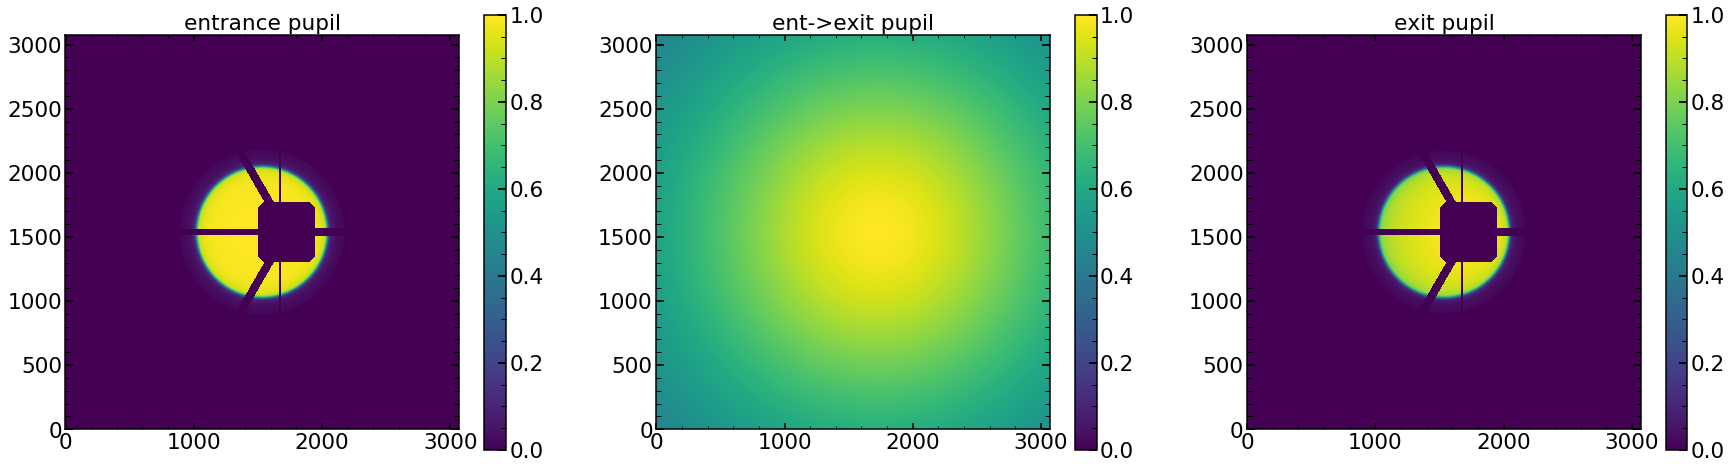

In [30]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

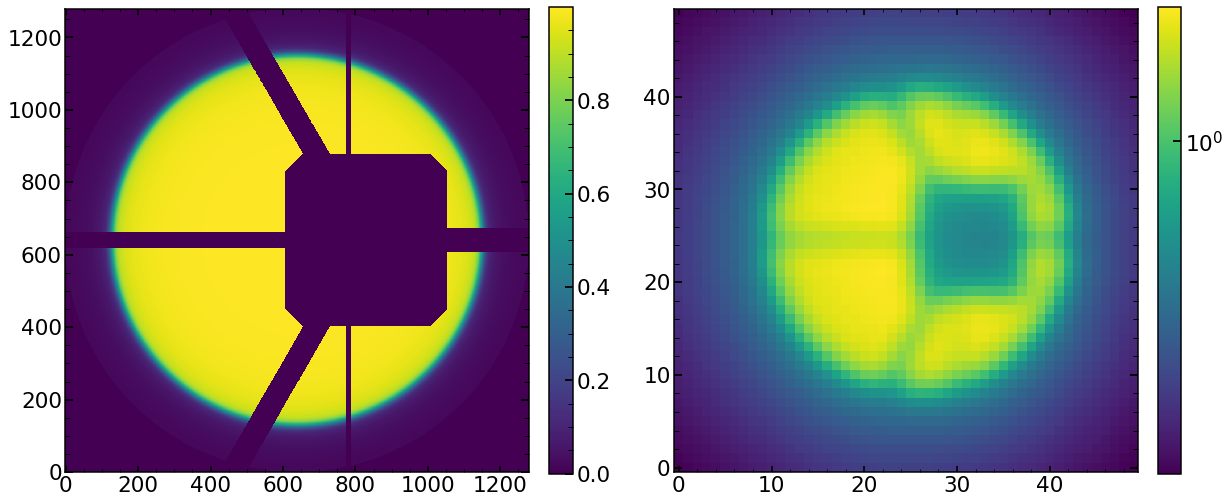

In [11]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([1,10**-2,10**-3,10**-4,10**-5,10,10**2,10**3,10**4,10**5])

# quality difference between real data and simulations 

In [37]:
from astropy.io import fits 

finalHgAr=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl')
image_index=1
run_5=21280+30
sci_5=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci"+str(run_5)+str(image_index)+'HgAr_Stacked.npy')

# HgAr
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/Jun_2019_run1/rerun/rerun_1/detrend/calExp/2019-07-26/'
data=fits.open(DATA_FOLDER+'v00'+str(run_5+0)+'/calExp-LA0'+str(run_5+0)+'r1.fits')
scidata_HgAr=data[1].data

# Ne
run_Ne=21484+5*6
DATA_FOLDER='/Volumes/My Passport for Mac/Old_Files/PFS/ReducedData/Jun_2019_run1/rerun/rerun_1/detrend/calExp/2019-07-26/'
data=fits.open(DATA_FOLDER+'v00'+str(run_Ne+0)+'/calExp-LA0'+str(run_Ne+0)+'r1.fits')
scidata_Ne=data[1].data

# sim 
DATA_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Sim/'
data=fits.open(DATA_FOLDER+'PFFAr1.fits')
scidata_sim=data[1].data

In [186]:
FA000031r1=astropy.io.fits.open('/Users/nevencaplar/Documents/PFS/ReducedData/v0000031/calExp-FA000031r1.fits')[1].data

Lower_left_31=FA000031r1[550-10:550+10,77-10:77+10]
Lower_right_31=FA000031r1[550-10:550+10,4019-10:4019+10]

Upper_left_31=FA000031r1[3495-10:3495+10,76-10:76+10]
Upper_right_31=FA000031r1[3495-10:3495+10,4020-10:4020+10]

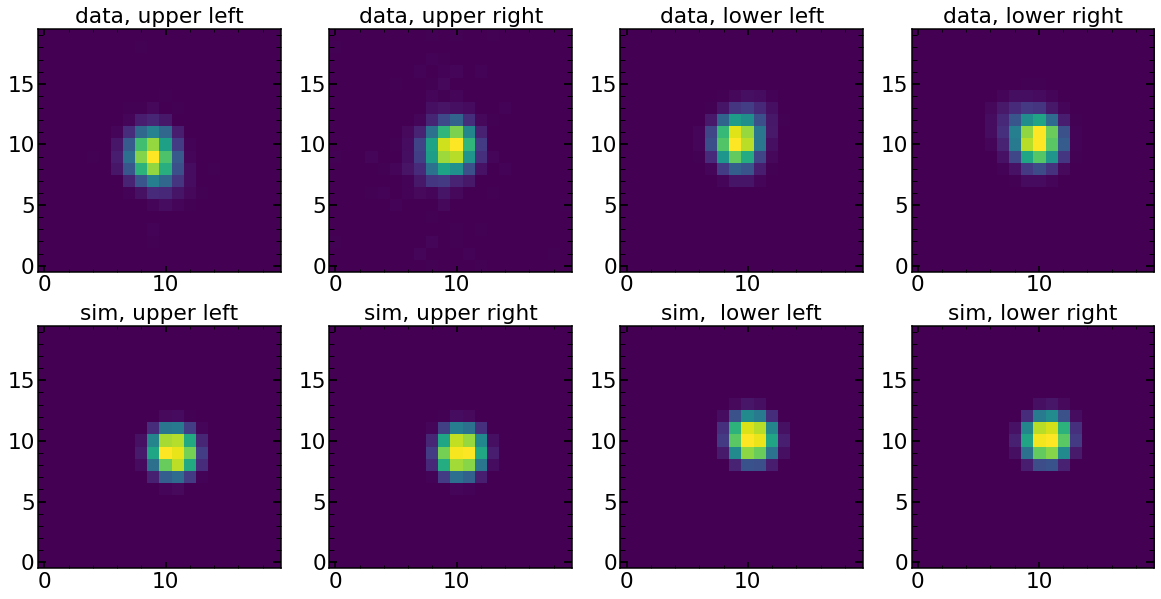

In [187]:
scidata_upper_left=scidata[4030:4050,50:70]
scidata_upper_right=scidata[4030:4050,4006:4026]
scidata_lower_left=scidata_Ne[140:160,53:73]
scidata_lower_right=scidata_Ne[141:161,4004:4024]


plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.title('data, upper left')
plt.imshow(scidata_upper_left,origin='lower',vmax=np.max(scidata_upper_left),vmin=np.max(scidata_upper_left)/100)
plt.subplot(2,4,2)
plt.title('data, upper right')
plt.imshow(scidata_upper_right,origin='lower',vmax=np.max(scidata_upper_right),vmin=np.max(scidata_upper_right)/100)
plt.subplot(2,4,3)
plt.title('data, lower left')
plt.imshow(scidata_lower_left,origin='lower',vmax=np.max(scidata_lower_left),vmin=np.max(scidata_lower_left)/100)
plt.subplot(2,4,4)
plt.title('data, lower right')
plt.imshow(scidata_lower_right,origin='lower',vmax=np.max(scidata_lower_right),vmin=np.max(scidata_lower_right)/100)

plt.subplot(2,4,5)
plt.title('sim, upper left')
plt.imshow(Upper_left_31,vmax=np.max(Upper_left_31),origin='lower',vmin=np.max(Upper_left_31)/10**2)
plt.subplot(2,4,6)
plt.title('sim, upper right')
plt.imshow(Upper_right_31,vmax=np.max(Upper_right_31),origin='lower',vmin=np.max(Upper_right_31)/10**2)
plt.subplot(2,4,7)
plt.title('sim,  lower left')
plt.imshow(Lower_left_31,vmax=np.max(Lower_left_31),origin='lower',vmin=np.max(Lower_left_31)/10**2)
plt.subplot(2,4,8)
plt.title('sim, lower right')
plt.imshow(Lower_right_31,vmax=np.max(Lower_right_31)/1,origin='lower',vmin=np.max(Lower_right_31)/10**2)

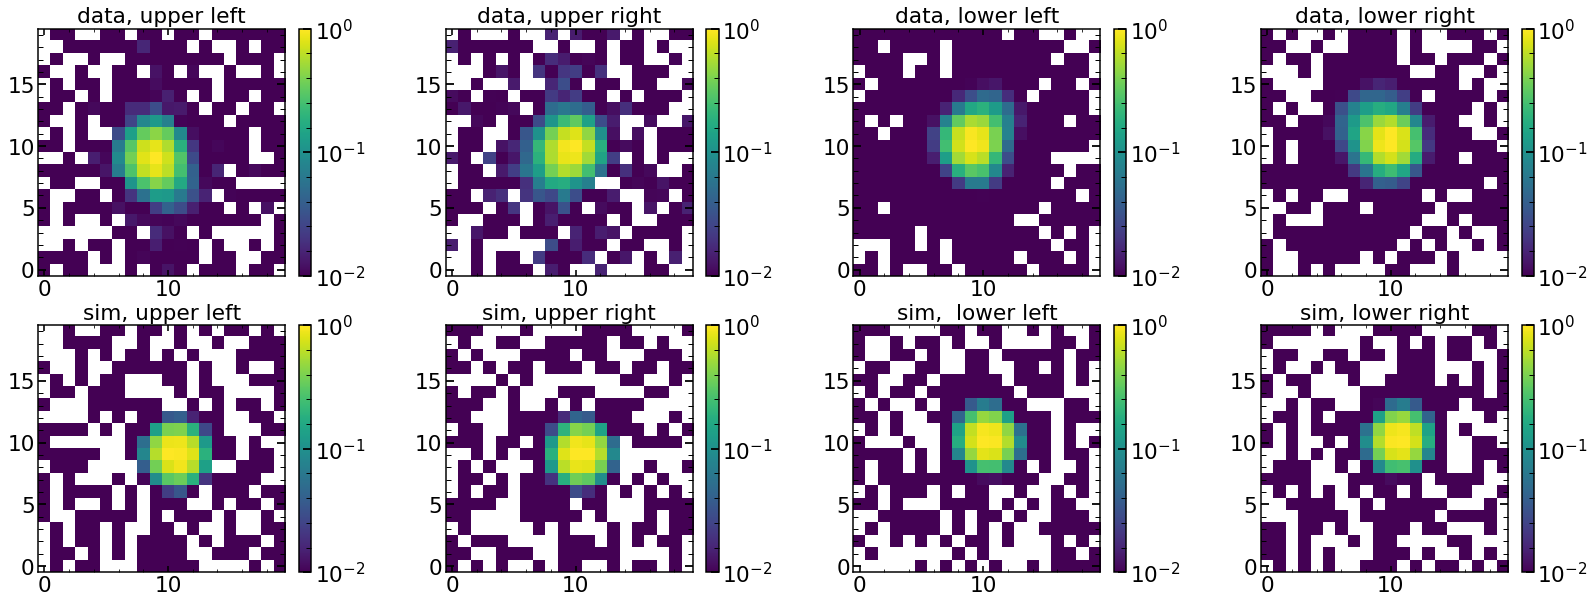

In [188]:
plt.figure(figsize=(28,10))
plt.subplot(2,4,1)
plt.title('data, upper left')
plt.imshow(scidata_upper_left/np.max(scidata_upper_left),origin='lower',vmax=1,vmin=1/100,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,2)
plt.title('data, upper right')
plt.imshow(scidata_upper_right/np.max(scidata_upper_right),origin='lower',vmax=1,vmin=1/100,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,3)
plt.title('data, lower left')
plt.imshow(scidata_lower_left/np.max(scidata_lower_left),origin='lower',vmax=1,vmin=1/100,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,4)
plt.title('data, lower right')
plt.imshow(scidata_lower_right/np.max(scidata_lower_right),origin='lower',vmax=1,vmin=1/100,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,5)
plt.title('sim, upper left')
plt.imshow(Upper_left_31/np.max(Upper_left_31),vmax=1,origin='lower',vmin=1/10**2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,6)
plt.title('sim, upper right')
plt.imshow(Upper_right_31/np.max(Upper_right_31),vmax=1,origin='lower',vmin=1/10**2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,7)
plt.title('sim,  lower left')
plt.imshow(Lower_left_31/np.max(Lower_left_31),vmax=1,origin='lower',vmin=1/10**2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

plt.subplot(2,4,8)
plt.title('sim, lower right')
plt.imshow(Lower_right_31/np.max(Lower_right_31),vmax=1,origin='lower',vmin=1/10**2,norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([0.01,0.1,1])

# Double simulating 

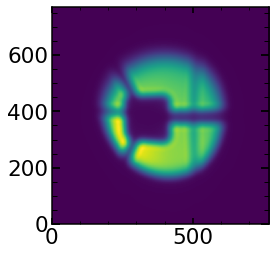

In [31]:
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
# run spot 1 from Dec04
plt.imshow(optPsf_cut_grating_convolved)

In [32]:
optPsf_cut_grating_convolved_2=np.copy(optPsf_cut_grating_convolved)
optPsf_cut_grating_convolved_second_image=np.zeros(optPsf_cut_grating_convolved.shape)

len(optPsf_cut_grating_convolved_2)

Dy2=170
Dx2=0

relative_flux=0.5

# optPsf_cut_grating_convolved_second_image[0:Dy2,:]=optPsf_cut_grating_convolved_2[len(optPsf_cut_grating_convolved_2)-Dy2:,:]*0.5

if Dy2>0:
    optPsf_cut_grating_convolved_second_image[Dy2:,:]=optPsf_cut_grating_convolved_2[0:len(optPsf_cut_grating_convolved_2)-Dy2,:]*relative_flux
if Dy2<0:
    optPsf_cut_grating_convolved_second_image[:Dy2,:]=optPsf_cut_grating_convolved_2[-Dy2:len(optPsf_cut_grating_convolved_2),:]*relative_flux

final_image=optPsf_cut_grating_convolved+optPsf_cut_grating_convolved_second_image

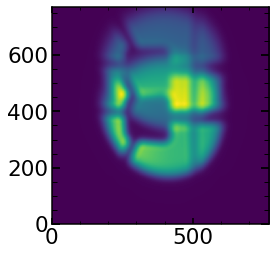

In [33]:
plt.imshow(final_image)

In [133]:
STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"  
arc='HgAr'
obs=21346+12
single_number=2
sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_realization=np.load(TESTING_FINAL_IMAGES_FOLDER+'single_realization.npy') 

In [162]:
sci_image_1d=np.sum(sci_image,axis=1)
var_image_1d=np.sum(var_image,axis=1)
single_realization_1d=np.sum(single_realization,axis=1)/np.sum(single_realization_1d)*np.sum(sci_image_1d)

print(np.sum(sci_image_1d))
print(np.sum(single_realization_1d))

7200015.0
7200015.000000001


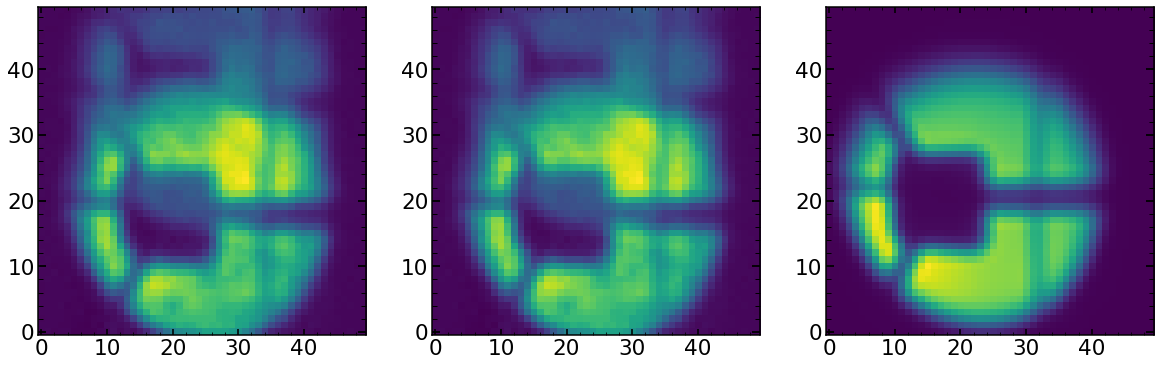

In [135]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(sci_image)
plt.subplot(1,3,2)
plt.imshow(var_image)
plt.subplot(1,3,3)
plt.imshow(single_realization)

In [38]:
second_image_fitting_res=[]
for i in range(-len(single_realization_1d),len(single_realization_1d)):
    for ratio in np.arange(0.05,0.7,0.01):
        if i >0:
            single_realization_1d_shifted=ratio*np.concatenate((single_realization_1d[i:len(single_realization_1d)],np.zeros(i,)))
        else:
            single_realization_1d_shifted=ratio*np.concatenate((np.zeros(-i,),single_realization_1d[-i:]))

        complete_realization_1d=single_realization_1d+ratio*single_realization_1d_shifted
        complete_realization_1d_renormalized=complete_realization_1d*np.sum(sci_image_1d)/np.sum(complete_realization_1d)
        second_image_fitting_res.append([i,ratio,np.mean((sci_image_1d-complete_realization_1d_renormalized)**2/var_image_1d)])
        
second_image_fitting_res=np.array(second_image_fitting_res)

NameError: name 'single_realization_1d' is not defined

In [31]:
second_image_fitting_res[second_image_fitting_res[:,2]==np.min(second_image_fitting_res[:,2])]

array([[    4.        ,     0.69      , 19620.50769773]])

In [32]:
i=1
ratio=0.69
if i >0:
    single_realization_1d_shifted=ratio*np.concatenate((single_realization_1d[i:len(single_realization_1d)],np.zeros(i,)))
else:
    single_realization_1d_shifted=ratio*np.concatenate((np.zeros(-i,),single_realization_1d[-i:]))
complete_realization_1d=single_realization_1d+ratio*single_realization_1d_shifted
complete_realization_1d_renormalized=complete_realization_1d*np.sum(sci_image_1d)/np.sum(complete_realization_1d)

single_realization_1d_renormalized=single_realization_1d*np.sum(sci_image_1d)/np.sum(complete_realization_1d)
single_realization_1d_shifted_renormalized=single_realization_1d_shifted*np.sum(sci_image_1d)/np.sum(complete_realization_1d)

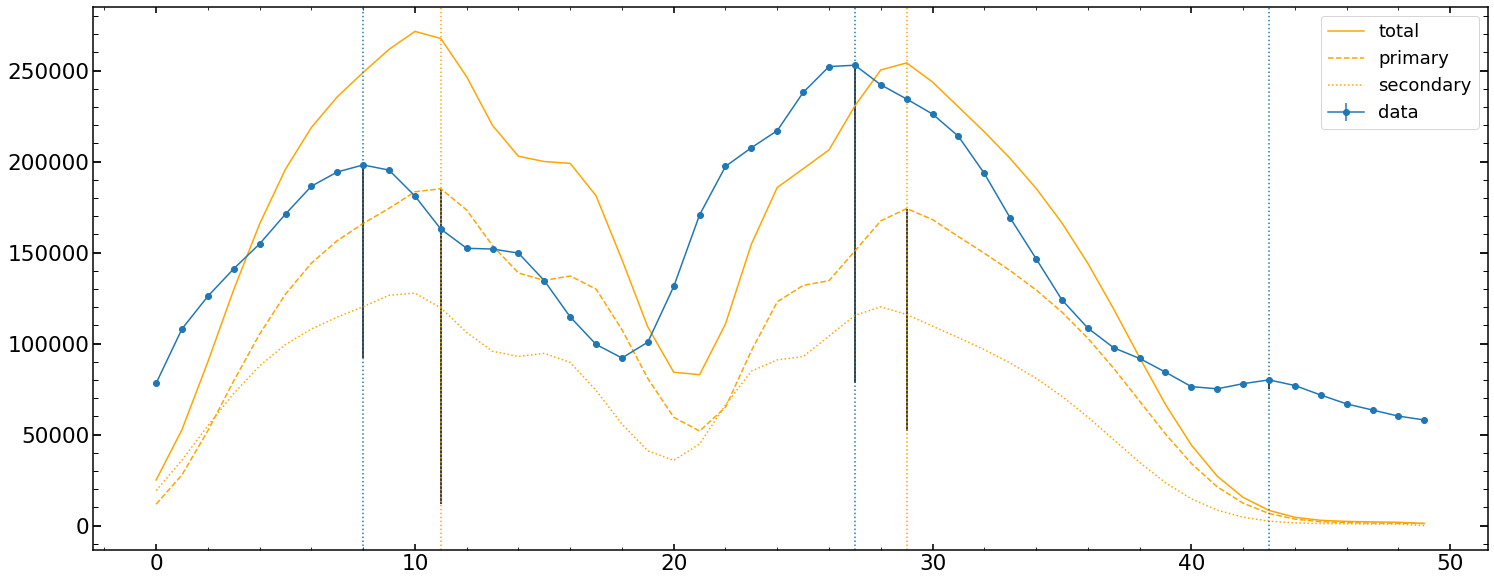

In [33]:
peaks_sci_data=scipy.signal.find_peaks(sci_image_1d)[0]
prominences_sci_data= scipy.signal.peak_prominences(sci_image_1d, peaks_sci_data)[0]
contour_heights_sci_image = sci_image_1d[peaks_sci_data] - prominences_sci_data


peaks_single_realization=scipy.signal.find_peaks(single_realization_1d_renormalized,prominence=np.max(single_realization_1d_renormalized)/4)[0]
prominences_single_realization= scipy.signal.peak_prominences(single_realization_1d_renormalized, peaks_single_realization)[0]
contour_heights_single_realization = single_realization_1d_renormalized[peaks_single_realization] - prominences_single_realization


plt.figure(figsize=(25,10))
plt.errorbar(range(len(sci_image_1d)),sci_image_1d,yerr=np.sqrt(var_image_1d),marker='o',label='data')
plt.plot(complete_realization_1d_renormalized,color='orange',label='total')
plt.plot(single_realization_1d_renormalized,color='orange',ls='--',label='primary')
plt.plot(single_realization_1d_shifted_renormalized,color='orange',ls=':',label='secondary')
plt.legend()
for i in range(len(peaks_sci_data)):
    plt.axvline(peaks_sci_data[i],ls=':')
    
for i in range(len(peaks_single_realization)):
    plt.axvline(peaks_single_realization[i],ls=':',color='orange')
    
plt.vlines(x=peaks_sci_data, ymin=contour_heights_sci_image, ymax=sci_image_1d[peaks_sci_data])    
plt.vlines(x=peaks_single_realization, ymin=contour_heights_single_realization, ymax=single_realization_1d_renormalized[peaks_single_realization])

In [34]:
sorted_prominences_sci_data=np.flip(np.sort(prominences_sci_data))
second_prominence_sci_data_value=sorted_prominences_sci_data[1]
third_prominence_sci_data_value=sorted_prominences_sci_data[2]
print(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value])
print(np.mean(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value]))

[ 8 27]
17.5


In [35]:
print(peaks_single_realization)
print(np.mean(peaks_single_realization))

[11 29]
20.0


In [36]:
modification_value=np.round(np.mean(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value])-np.mean(peaks_single_realization)).astype(int)
modification_value

-2

In [37]:
third_peak_positions=peaks_sci_data[prominences_sci_data==third_prominence_sci_data_value][0]
third_peak_positions

43

In [38]:
offset_second_image=27-third_peak_positions
offset_second_image

-16

In [39]:
single_realization_1d_modified=np.concatenate((single_realization_1d[-modification_value:],np.zeros(-modification_value,)))

In [40]:
peaks_sci_data=scipy.signal.find_peaks(sci_image_1d)[0]
prominences_sci_data= scipy.signal.peak_prominences(sci_image_1d, peaks_sci_data)[0]
contour_heights_sci_image = sci_image_1d[peaks_sci_data] - prominences_sci_data
peak_values_sci_data=sci_image_1d[peaks_sci_data]

sorted_prominences_sci_data=np.flip(np.sort(prominences_sci_data))
sorted_values_single_sci_data=np.flip(np.sort(peak_values_sci_data))

second_prominence_sci_data_value=sorted_prominences_sci_data[1]
second_value_sci_data_value=sorted_values_single_sci_data[1]

third_prominence_sci_data_value=sorted_prominences_sci_data[2]
mean_sci_data_peaks=np.mean(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value])
print(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value])
print(mean_sci_data_peaks)




peaks_single_realization=scipy.signal.find_peaks(single_realization_1d,prominence=np.max(single_realization_1d)/4)[0]
prominences_single_realization= scipy.signal.peak_prominences(single_realization_1d, peaks_single_realization)[0]
contour_heights_single_realization = single_realization_1d[peaks_single_realization] - prominences_single_realization
peak_values_single_realization=single_realization_1d[peaks_single_realization]

sorted_prominences_single_realization=np.flip(np.sort(prominences_single_realization))
sorted_values_single_realization=np.flip(np.sort(peak_values_single_realization))

second_prominence_single_realization_value=prominences_single_realization[1]
second_value_single_realization_value=sorted_values_single_realization[1]

position_of_second_prominance_single_realization=peaks_single_realization[prominences_single_realization==second_prominence_single_realization_value]
mean_single_realization_peaks=np.mean(peaks_single_realization[prominences_single_realization>=second_prominence_single_realization_value])
print(peaks_single_realization[prominences_single_realization>=second_prominence_single_realization_value])
print(mean_single_realization_peaks)


[ 8 27]
17.5
[11 29]
20.0


In [41]:
second_value_sci_data_value

198172.55

In [42]:
primary_offset_from_single_realization=int(mean_sci_data_peaks-mean_single_realization_peaks)
primary_offset_from_single_realization

single_realization_1d_primary_v0=np.concatenate((single_realization_1d[-primary_offset_from_single_realization:],np.zeros(-primary_offset_from_single_realization,)))

renormalization_primary=second_value_sci_data_value/second_value_single_realization_value
single_realization_1d_primary_v1=renormalization_primary*single_realization_1d_primary_v0

secondary_offset_proposal_res=[]
ratio_secondary=np.sum(sci_image_1d)/np.sum(single_realization_1d_primary_v1)-1

for secondary_offset_proposal in range(-20,21):
    if secondary_offset_proposal >=0:
        single_realization_1d_secondary_v0=np.concatenate((single_realization_1d_primary_v1[secondary_offset_proposal:len(single_realization_1d_primary_v1)],np.zeros(secondary_offset_proposal,)))
    else:
        single_realization_1d_secondary_v0=np.concatenate((np.zeros(-secondary_offset_proposal,),single_realization_1d_primary_v1[:secondary_offset_proposal]))    
    single_realization_1d_secondary_v1=ratio_secondary*single_realization_1d_secondary_v0    
    complete_realization_1d=single_realization_1d_primary_v1+single_realization_1d_secondary_v1
    secondary_offset_proposal_res.append([secondary_offset_proposal,np.mean((complete_realization_1d-sci_image_1d)**2/var_image_1d)])
    
secondary_offset_proposal_res=np.array(secondary_offset_proposal_res)
secondary_offset_best_proposal=int(secondary_offset_proposal_res[secondary_offset_proposal_res[:,1]==np.min(secondary_offset_proposal_res[:,1])][0][0])

secondary_offset_proposal=secondary_offset_best_proposal
if secondary_offset_proposal >=0:
    single_realization_1d_secondary_v0=np.concatenate((single_realization_1d_primary_v1[secondary_offset_proposal:len(single_realization_1d_primary_v1)],np.zeros(secondary_offset_proposal,)))
else:
    single_realization_1d_secondary_v0=np.concatenate((np.zeros(-secondary_offset_proposal,),single_realization_1d_primary_v1[:secondary_offset_proposal]))    
single_realization_1d_secondary_v1=ratio_secondary*single_realization_1d_secondary_v0    
complete_realization_1d=single_realization_1d_primary_v1+single_realization_1d_secondary_v1


In [43]:
secondary_offset_best_proposal

-17

In [20]:
sci_image_1d

NameError: name 'sci_image_1d' is not defined

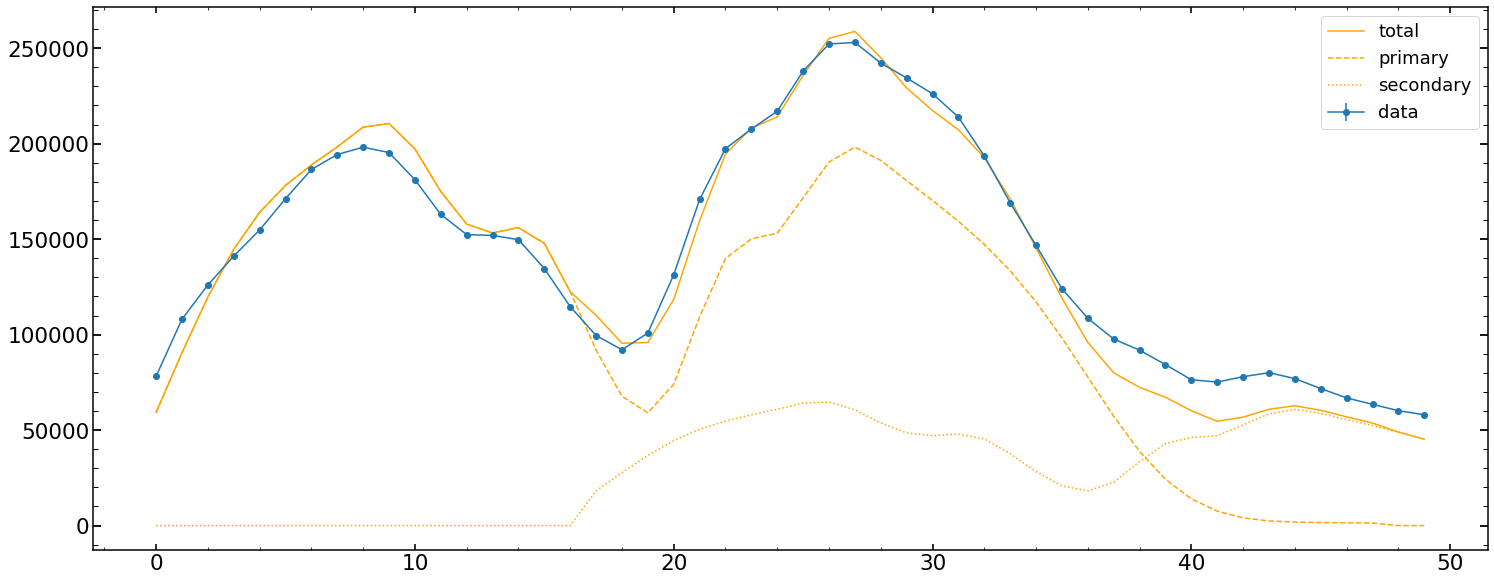

In [44]:
plt.figure(figsize=(25,10))
plt.errorbar(range(len(sci_image_1d)),sci_image_1d,yerr=np.sqrt(var_image_1d),marker='o',label='data')
plt.plot(complete_realization_1d,color='orange',label='total')
plt.plot(single_realization_1d_primary_v1,color='orange',ls='--',label='primary')
plt.plot(single_realization_1d_secondary_v1,color='orange',ls=':',label='secondary')
plt.legend()
#for i in range(len(peaks_sci_data)):
#    plt.axvline(peaks_sci_data[i],ls=':')
    
#for i in range(len(peaks_single_realization)):
#    plt.axvline(peaks_single_realization[i],ls=':',color='orange')
    
#plt.vlines(x=peaks_sci_data, ymin=contour_heights_sci_image, ymax=sci_image_1d[peaks_sci_data])    
#plt.vlines(x=peaks_single_realization, ymin=contour_heights_single_realization, ymax=single_realization_1d_renormalized[peaks_single_realization])

In [ ]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (sqrt(2*pi) * wid)) * exp(-(x-cen)**2 / (2*wid**2))


In [186]:
v_flux=1
sci_image_1d_vflux=v_flux*sci_image_1d

def primary_secondary_ratio(x):
    print(x)
    primary_offset_from_single_realization=int(x[0])
    secondary_offset=int(x[1])
    ratio_secondary=x[2]
    
    try:
    
        if primary_offset_from_single_realization >=0:
            single_realization_1d_primary_v0=np.concatenate((single_realization_1d[primary_offset_from_single_realization:len(single_realization_1d)],np.zeros(primary_offset_from_single_realization,)))
        else:
            single_realization_1d_primary_v0=np.concatenate((np.zeros(-primary_offset_from_single_realization,),single_realization_1d[:primary_offset_from_single_realization]))  

        if secondary_offset >=0:
            single_realization_1d_secondary_v0=ratio_secondary*np.concatenate((single_realization_1d_primary_v0[secondary_offset:len(single_realization_1d_primary_v0)],np.zeros(secondary_offset,)))
        else:
            single_realization_1d_secondary_v0=ratio_secondary*np.concatenate((np.zeros(-secondary_offset,),single_realization_1d_primary_v0[:secondary_offset]))  

        complete_realization_1d=single_realization_1d_primary_v0+single_realization_1d_secondary_v0
        complete_realization_1d_renormalized=complete_realization_1d*(np.sum(sci_image_1d)*v_flux/np.sum(complete_realization_1d))
        print(np.mean((sci_image_1d-complete_realization_1d_renormalized)**2/var_image_1d))
        return np.mean((sci_image_1d-complete_realization_1d_renormalized)**2/var_image_1d)
    except:
        return 10000000000

In [187]:
initial_simplex=[]
for i,j,l in product([-5,5],[-20,20],[0.1,0.8]):
    initial_simplex.append([i,j,l])
    
initial_simplex=np.array(initial_simplex)
initial_simplex=initial_simplex[2:6]
initial_simplex

array([[ -5. ,  20. ,   0.1],
       [ -5. ,  20. ,   0.8],
       [  5. , -20. ,   0.1],
       [  5. , -20. ,   0.8]])

In [208]:
scipy.optimize.minimize(primary_secondary_ratio,np.array((0,-16,0.4),), method='Nelder-Mead',options={'initial_simplex':initial_simplex})

[-5.  20.   0.1]
70111.82318815518
[-5.  20.   0.8]
65284.20573391286
[  5.  -20.    0.1]
28090.78818299456
[  5.  -20.    0.8]
14963.46415920292
[  8.33333333 -33.33333333   1.03333333]
45674.65846619349
[ 17.22222222 -68.88888889   0.48888889]
[ 0.55555556 -2.22222222  0.72222222]
31572.9947826573
[-1.2962963   5.18518519  0.04814815]
32811.6524988295
[ 1.11111111 -4.44444444  0.29444444]
21929.056493879027
[  6.85185185 -27.40740741   0.07407407]
43063.220419749974
[ 2.12962963 -8.51851852  0.56018519]
14786.87794135753
[ 0.49382716 -1.97530864  1.00308642]
30846.91277121889
[  3.87345679 -15.49382716   0.3257716 ]
3016.162642474378
[  6.22427984 -24.89711934   0.82952675]
17428.981462435022
[  4.94598765 -19.78395062   0.69575617]
9628.5258060567
[ 2.29938272 -9.19753086  0.25447531]
11414.794220243273
[  5.28292181 -21.13168724   0.29048354]
13639.527048285503
[  4.49459877 -17.97839506   0.35790895]
7234.129429857084
[  6.57664609 -26.30658436   0.66514918]
13526.706282099318
[  

 final_simplex: (array([[  3.84488875, -15.37955498,   0.4072938 ],
       [  3.84490137, -15.37960549,   0.40729301],
       [  3.84491313, -15.37965253,   0.4072941 ],
       [  3.84489886, -15.37959542,   0.40729267]]), array([2518.36434958, 2518.36434959, 2518.3643496 , 2518.36434962]))
           fun: 2518.3643495810247
       message: 'Optimization terminated successfully.'
          nfev: 124
           nit: 62
        status: 0
       success: True
             x: array([  3.84488875, -15.37955498,   0.4072938 ])

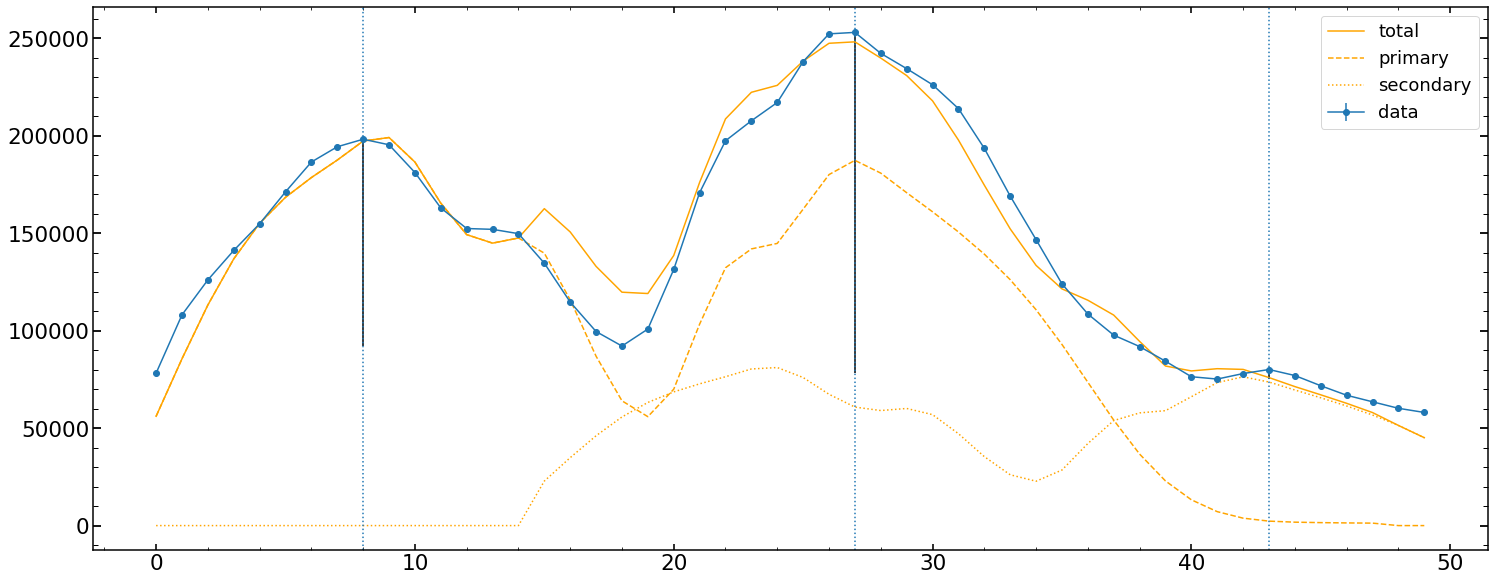

In [205]:
peaks_sci_data=scipy.signal.find_peaks(sci_image_1d)[0]
prominences_sci_data= scipy.signal.peak_prominences(sci_image_1d, peaks_sci_data)[0]
contour_heights_sci_image = sci_image_1d[peaks_sci_data] - prominences_sci_data


#peaks_single_realization=scipy.signal.find_peaks(single_realization_1d_renormalized,prominence=np.max(single_realization_1d_renormalized)/4)[0]
#prominences_single_realization= scipy.signal.peak_prominences(single_realization_1d_renormalized, peaks_single_realization)[0]
#contour_heights_single_realization = single_realization_1d_renormalized[peaks_single_realization] - prominences_single_realization


plt.figure(figsize=(25,10))
plt.errorbar(range(len(sci_image_1d)),sci_image_1d,yerr=np.sqrt(var_image_1d),marker='o',label='data')
plt.plot(complete_realization_1d_renormalized,color='orange',label='total')
plt.plot(single_realization_1d_primary_v1,color='orange',ls='--',label='primary')
plt.plot(single_realization_1d_secondary_v1,color='orange',ls=':',label='secondary')
plt.legend()

for i in range(len(peaks_sci_data)):
    plt.axvline(peaks_sci_data[i],ls=':')
    
#for i in range(len(peaks_single_realization)):
#    plt.axvline(peaks_single_realization[i],ls=':',color='orange')
    
plt.vlines(x=peaks_sci_data, ymin=contour_heights_sci_image, ymax=sci_image_1d[peaks_sci_data])    
#plt.vlines(x=peaks_single_realization, ymin=contour_heights_single_realization, ymax=single_realization_1d_renormalized[peaks_single_realization])


In [146]:
i=0
ratio=0.69
if i>0:
    single_realization_1d_shifted=ratio*np.concatenate((single_realization_1d[i:len(single_realization_1d)],np.zeros(i,)))
else:
    single_realization_1d_shifted=ratio*np.concatenate((np.zeros(-i,),single_realization_1d[-i:]))

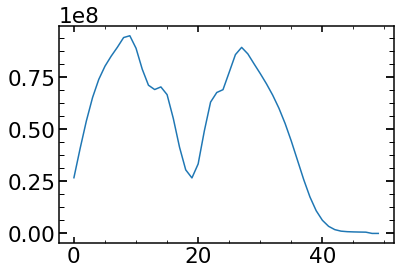

In [147]:
plt.plot(single_realization_1d_shifted)

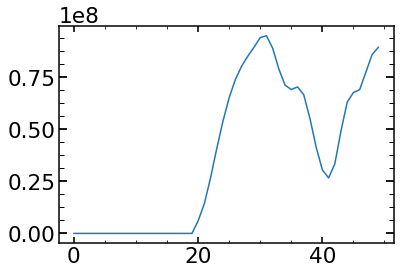

In [276]:
i=-20
ratio=0.69
if i>0:
    single_realization_1d_shifted=ratio*np.concatenate((single_realization_1d[i:len(single_realization_1d)],np.zeros(i,)))
else:
    single_realization_1d_shifted=ratio*np.concatenate((np.zeros(-i,),single_realization_1d[:i]))
    
plt.plot(single_realization_1d_shifted)

In [111]:
np.mean(peaks_sci_data[prominences_sci_data>=second_prominence_sci_data_value])-np.mean(peaks_single_realization)

-2.5

In [90]:
peaks_single_realization


array([11, 29])

In [81]:
peaks, _ = scipy.signal.find_peaks(single_realization_1d_renormalized)
prominences = scipy.signal.peak_prominences(single_realization_1d_renormalized, peaks)[0]
contour_heights = single_realization_1d_renormalized[peaks] - prominences

In [77]:
prominences

array([106080.171875 , 174776.8515625,   4902.6015625])

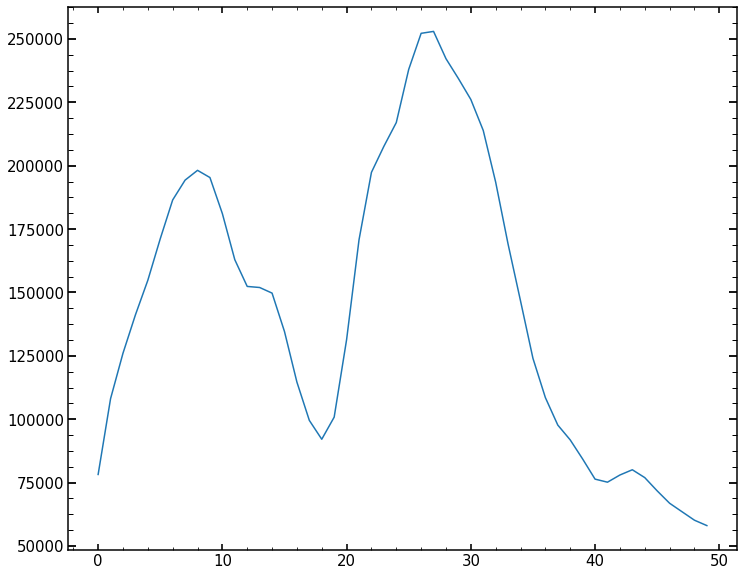

In [160]:
plt.plot(np.sum(sci_image,axis=1))

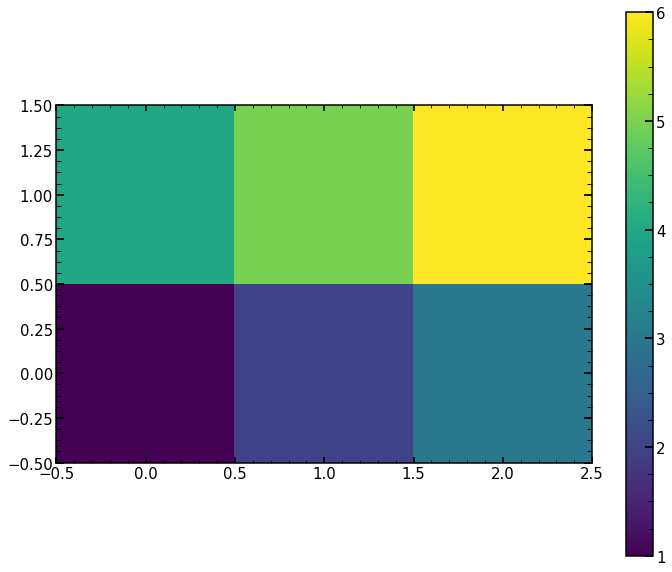

In [154]:
plt.imshow(np.array(([1,2,3],[4,5,6])))
plt.colorbar()

In [151]:
np.sum(np.array(([1,2,3],[4,5,6])),axis=0)

array([5, 7, 9])

In [152]:
np.sum(np.array(([1,2,3],[4,5,6])),axis=1)

array([ 6, 15])

In [164]:
0.75*2.5

1.875

In [12]:
from pulp import *

In [77]:
prob = LpProblem("Center_two",LpMinimize)
possible_delta1_values=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
possible_delta2_values=list(np.array(range(-20,21)))

i=1
j=2

primary_offset_from_single_realization=possible_delta1_values[i]
secondary_offset_proposal=possible_delta2_values[j]


v_flux=1
sci_image_1d_vflux=v_flux*sci_image_1d

def primary_secondary_ratio(x):
    primary_offset_from_single_realization=int(x[0])
    secondary_offset=int(x[1])
    ratio_secondary=x[2]
    
    if primary_offset_from_single_realization >=0:
        single_realization_1d_primary_v0=ratio_secondary*np.concatenate((single_realization_1d[primary_offset_from_single_realization:len(single_realization_1d)],np.zeros(primary_offset_from_single_realization,)))
    else:
        single_realization_1d_primary_v0=ratio_secondary*np.concatenate((np.zeros(-primary_offset_from_single_realization,),single_realization_1d[:primary_offset_from_single_realization]))  
    
    if secondary_offset >=0:
        single_realization_1d_secondary_v0=ratio_secondary*np.concatenate((single_realization_1d_primary_v0[secondary_offset:len(single_realization_1d_primary_v0)],np.zeros(secondary_offset,)))
    else:
        single_realization_1d_secondary_v0=ratio_secondary*np.concatenate((np.zeros(-secondary_offset,),single_realization_1d_primary_v0[:secondary_offset]))  

    complete_realization_1d=single_realization_1d_primary_v0+single_realization_1d_secondary_v0
    complete_realization_1d_renormalized=complete_realization_1d*(np.sum(sci_image_1d)*v_flux/np.sum(complete_realization_1d))
    
    return np.mean((sci_image_1d_vflux-complete_realization_1d_renormalized)**2/var_image_1d)

In [61]:
from itertools import   product

In [78]:
prob = LpProblem("Offset",LpMinimize)
x1=LpVariable("ChickenPercent",0,None,LpInteger)
x2=LpVariable("BeefPercent",0,None,LpInteger)

In [79]:
prob +=primary_secondary_ratio([x1,x2,0.69]),

TypeError: int() argument must be a string, a bytes-like object or a number, not 'LpVariable'

In [65]:
prob.solve()

1

In [66]:
print("Status:", LpStatus[prob.status])

Status: Optimal


In [67]:
for v in prob.variables():
    if v.varValue>0:
        print(v.name, "=", v.varValue)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [68]:
 prob.variables

<bound method LpProblem.variables of Center_two:
MINIMIZE
0*__dummy + 10278222.820416767
VARIABLES
__dummy = 0 Continuous
>

In [70]:
primary_secondary_ratio([2,5,0.69])

19185.86107538082

# Zemax - wavefront

## init 

In [ ]:
# copying from Compare result of the fits to the real data with the outputs from Zemax (PIPE2D-421)

In [117]:
from astropy.io import fits
detectorMapOriginal=fits.open('/Users/nevencaplar/Documents/PFS/DetectorMap/detectorMap-sim-1-r.fits')

hdu = detectorMapOriginal["FIBERID"]
fiberIds = hdu.data
fiberIds = fiberIds.astype(np.int32) 
fiberIds.shape

list_of_illuminated_slit_fibers_in_January_24_data=[32,63,111,192,223,255,289,308,342,401,418,464,518,525,587,620]

list_of_illuminated_science_fibers_in_January_24_data=[]
for i in list_of_illuminated_slit_fibers_in_January_24_data:
    list_of_illuminated_science_fibers_in_January_24_data.append(np.where(fiberIds==i)[0][0])
    
list_of_illuminated_science_fibers_in_January_24_data


detectorMapOriginal_for_illuminated_fiber_Jan_24_2019_as_list_x=[]
detectorMapOriginal_for_illuminated_fiber_Jan_24_2019_as_list_y=[]
for j in list_of_illuminated_science_fibers_in_January_24_data:
    print(j)
    detectorMapOriginal_single_fiber_x=detectorMapOriginal[3].data[detectorMapOriginal[3].data['index']==j]    
    detectorMapOriginal_single_fiber_y=detectorMapOriginal[4].data[detectorMapOriginal[4].data['index']==j]
    
    detectorMapOriginal_single_fiber_as_list_x=[]
    detectorMapOriginal_single_fiber_as_list_y=[]
    # because I do not know how to work with numpy.record
    for i in range(len(detectorMapOriginal_single_fiber_y)):
        detectorMapOriginal_single_fiber_as_list_x.append(list(detectorMapOriginal_single_fiber_x[i]))
        detectorMapOriginal_single_fiber_as_list_y.append(list(detectorMapOriginal_single_fiber_y[i]))
        
    detectorMapOriginal_single_fiber_as_array_x=np.array(detectorMapOriginal_single_fiber_as_list_x)
    detectorMapOriginal_single_fiber_as_array_y=np.array(detectorMapOriginal_single_fiber_as_list_y)
    detectorMapOriginal_for_illuminated_fiber_Jan_24_2019_as_list_x.append(detectorMapOriginal_single_fiber_as_array_x)
    detectorMapOriginal_for_illuminated_fiber_Jan_24_2019_as_list_y.append(detectorMapOriginal_single_fiber_as_array_y)

30
59
104
180
211
241
273
292
305
362
379
423
472
479
538
569


In [118]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


list_of_dy_values_in_fibers=[]
for fibers in [303,271,239,209,176,146,116,84,52,22,5,595,328,359,390,423,453,484,514,547,578]:
    list_of_values=[]
    for wavelengths in [630,664,698,732,766,800,834,868,902,936,970]:
        nearest_value=find_nearest(np.array(detectorMapOriginal[4].data[detectorMapOriginal[3].data['index']==fibers])['value'],wavelengths)
        index_of_value=list(np.array(detectorMapOriginal[4].data[detectorMapOriginal[3].data['index']==fibers])['value']).index(nearest_value)
        list_of_values.append(index_of_value)
    list_of_dy_values_in_fibers.append(list_of_values)

In [119]:
list_of_dy_values_in_fibers=np.transpose(np.array(list_of_dy_values_in_fibers)).ravel()
list_of_dy_values_in_fibers

array([  82,   83,   84,   86,   88,   91,   95,  100,  105,  110,  113,
        113,   83,   84,   86,   88,   91,   95,  100,  105,  110,  478,
        478,  480,  482,  484,  488,  492,  497,  502,  508,  511,  512,
        478,  480,  482,  484,  488,  492,  497,  502,  508,  873,  874,
        875,  877,  880,  884,  888,  894,  900,  906,  910,  910,  874,
        875,  877,  880,  884,  889,  894,  900,  907, 1269, 1269, 1271,
       1273, 1276, 1280, 1285, 1291, 1298, 1305, 1309, 1309, 1269, 1271,
       1273, 1276, 1280, 1285, 1291, 1298, 1305, 1664, 1665, 1667, 1669,
       1672, 1677, 1682, 1688, 1695, 1703, 1707, 1708, 1665, 1666, 1669,
       1672, 1677, 1682, 1688, 1695, 1703, 2060, 2060, 2062, 2065, 2068,
       2073, 2078, 2085, 2093, 2101, 2106, 2106, 2060, 2062, 2065, 2068,
       2073, 2079, 2085, 2093, 2101, 2455, 2456, 2458, 2460, 2464, 2469,
       2475, 2483, 2490, 2499, 2505, 2505, 2456, 2458, 2460, 2464, 2469,
       2475, 2482, 2490, 2500, 2851, 2851, 2853, 28

In [120]:
def rotate_WaveField(minchain_wave_11_field_11):
    WaveField_upper_left_only_z4_to_z22=np.copy(minchain_wave_11_field_11[3:22])
    WaveField_upper_left_only_z4_to_z22_modified=np.zeros((19))

    # z4_new = z4_old
    WaveField_upper_left_only_z4_to_z22_modified[0]=WaveField_upper_left_only_z4_to_z22[0]

    # z5_new = -z5_old
    WaveField_upper_left_only_z4_to_z22_modified[0+1]=-WaveField_upper_left_only_z4_to_z22[0+1]
    # z6_new = -z6_old
    WaveField_upper_left_only_z4_to_z22_modified[1+1]=-WaveField_upper_left_only_z4_to_z22[1+1]
    
    # z7_new = z8_old
    WaveField_upper_left_only_z4_to_z22_modified[2+1]=WaveField_upper_left_only_z4_to_z22[3+1]
    # z8_new = -z7_old
    WaveField_upper_left_only_z4_to_z22_modified[3+1]=-WaveField_upper_left_only_z4_to_z22[2+1]
    
    # z9_new = -z10_old
    WaveField_upper_left_only_z4_to_z22_modified[4+1]=-WaveField_upper_left_only_z4_to_z22[5+1]
    # z10_new = z9_old
    WaveField_upper_left_only_z4_to_z22_modified[5+1]=WaveField_upper_left_only_z4_to_z22[4+1]
    
    # z11_new = z11_old
    WaveField_upper_left_only_z4_to_z22_modified[6+1]=WaveField_upper_left_only_z4_to_z22[6+1]
    
    # z12_new = -z12_old
    WaveField_upper_left_only_z4_to_z22_modified[7+1]=-WaveField_upper_left_only_z4_to_z22[7+1]
    # z13_new = -z13_old
    WaveField_upper_left_only_z4_to_z22_modified[8+1]=-WaveField_upper_left_only_z4_to_z22[8+1]
    
    # z14_new = z14_old
    WaveField_upper_left_only_z4_to_z22_modified[9+1]=WaveField_upper_left_only_z4_to_z22[9+1]
    # z15_new = z15_old
    WaveField_upper_left_only_z4_to_z22_modified[10+1]=WaveField_upper_left_only_z4_to_z22[10+1]
    
    # z16_new = -z17_old
    WaveField_upper_left_only_z4_to_z22_modified[11+1]=-WaveField_upper_left_only_z4_to_z22[12+1]
    # z17_new = z16_old
    WaveField_upper_left_only_z4_to_z22_modified[12+1]=-WaveField_upper_left_only_z4_to_z22[11+1]
    
    # z18_new = z19_old
    WaveField_upper_left_only_z4_to_z22_modified[13+1]=WaveField_upper_left_only_z4_to_z22[14+1]
    # z19_new = -z18_old
    WaveField_upper_left_only_z4_to_z22_modified[14+1]=-WaveField_upper_left_only_z4_to_z22[13+1]
    
    # z20_new = -z21_old
    WaveField_upper_left_only_z4_to_z22_modified[15+1]=-WaveField_upper_left_only_z4_to_z22[16+1]
    # z21_new = z20_old
    WaveField_upper_left_only_z4_to_z22_modified[16+1]=WaveField_upper_left_only_z4_to_z22[15+1]

    minchain_wave_11_field_11_rotated=np.copy(minchain_wave_11_field_11)
    minchain_wave_11_field_11_rotated[3:22]=WaveField_upper_left_only_z4_to_z22_modified
    return minchain_wave_11_field_11_rotated

In [121]:
wave_position=[]
for i in range(11):
    wave_position.append(int(i*4096/10))
    
wave_position

[0, 409, 819, 1228, 1638, 2048, 2457, 2867, 3276, 3686, 4096]

In [122]:
#wave_position=[100,425,840,1230,1650,2020,2400,2740,3200,3600,4000]
field_position=[2048,2252,2457,2662,2867,3072,3276,3481,3686,3891,4096,0,1843,1638,1433,1228,1024,819,614,409,204]

postion_res=[]
WaveField_res=[]
WaveField_res_0=[]
for wave in [1,2,3,4,5,6,7,8,9,10,11]:
    for field in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
        f = io.open('/Users/nevencaplar/Documents/PFS/FromZemax/July8_focus/Wave_'+str(wave)+'_Field_'+str(field)+'.txt', 'rt', encoding='utf-16')
        lines=f.read()
        # Reading of file
        #WaveField = np.genfromtxt(io.BytesIO(lines.encode('latin-1')), skip_header=17, delimiter=b'\t')
        WaveField = np.genfromtxt(io.BytesIO(lines.encode('latin-1')), skip_header=38, delimiter='\t')[:,1]
        WaveField_res.append(rotate_WaveField(WaveField))
        WaveField_res_0.append(rotate_WaveField(WaveField))
        postion_res.append([wave_position[wave-1],field_position[field-1]])

In [123]:
def wavelength_correction(single_Zernike_res_z5):

    res=[]
    wavelengths=[630,664,698,732,766,800,834,868,902,936,970]
    for i in range(11):
        wavelength=wavelengths[i]
        res.append((np.split(np.array(single_Zernike_res_z5),11)[i])*(wavelength/800))
    res=np.array(res)
    return res.ravel()

In [124]:
Zemax_number=4
single_Zernike_res_z2=[]
single_Zernike_res_z3=[]
single_Zernike_res_z4=[]
single_Zernike_res_z5=[]
single_Zernike_res_z6=[]
single_Zernike_res_z7=[]
single_Zernike_res_z8=[]
single_Zernike_res_z9=[]
single_Zernike_res_z10=[]
single_Zernike_res_z11=[]
single_Zernike_res_z12=[]
single_Zernike_res_z13=[]
single_Zernike_res_z14=[]
single_Zernike_res_z15=[]
single_Zernike_res_z16=[]
single_Zernike_res_z17=[]
single_Zernike_res_z18=[]
single_Zernike_res_z19=[]
single_Zernike_res_z20=[]
single_Zernike_res_z21=[]
single_Zernike_res_z22=[]
single_Zernike_res_z74=[]
single_Zernike_res_z159=[]





position_Zernike_res=[]

for i in range(len(WaveField_res)):
    single_Zernike_res_z2.append(WaveField_res[i][2-1])   
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z2_wavelength_corrected=wavelength_correction(single_Zernike_res_z2)

for i in range(len(WaveField_res)):
    single_Zernike_res_z3.append(WaveField_res[i][3-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z3_wavelength_corrected=wavelength_correction(single_Zernike_res_z3)


for i in range(len(WaveField_res)):
    single_Zernike_res_z4.append(WaveField_res[i][4-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z4_wavelength_corrected=wavelength_correction(single_Zernike_res_z4)

    
for i in range(len(WaveField_res)):
    single_Zernike_res_z5.append(WaveField_res[i][5-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z5_wavelength_corrected=wavelength_correction(single_Zernike_res_z5)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z6.append(WaveField_res[i][6-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z6_wavelength_corrected=wavelength_correction(single_Zernike_res_z6)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z7.append(WaveField_res[i][7-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z7_wavelength_corrected=wavelength_correction(single_Zernike_res_z7)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z8.append(WaveField_res[i][8-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z8_wavelength_corrected=wavelength_correction(single_Zernike_res_z8)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z9.append(WaveField_res[i][9-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z9_wavelength_corrected=wavelength_correction(single_Zernike_res_z9)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z10.append(WaveField_res[i][10-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z10_wavelength_corrected=wavelength_correction(single_Zernike_res_z10)

    
for i in range(len(WaveField_res)):
    single_Zernike_res_z11.append(WaveField_res[i][11-1])
    position_Zernike_res.append(postion_res[i])
single_Zernike_res_z11_wavelength_corrected=wavelength_correction(single_Zernike_res_z11)

for i in range(len(WaveField_res)):
    single_Zernike_res_z12.append(WaveField_res[i][12-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z12_wavelength_corrected=wavelength_correction(single_Zernike_res_z12)

for i in range(len(WaveField_res)):
    single_Zernike_res_z13.append(WaveField_res[i][13-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z13_wavelength_corrected=wavelength_correction(single_Zernike_res_z13)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z14.append(WaveField_res[i][14-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z14_wavelength_corrected=wavelength_correction(single_Zernike_res_z14)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z15.append(WaveField_res[i][15-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z15_wavelength_corrected=wavelength_correction(single_Zernike_res_z15)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z16.append(WaveField_res[i][16-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z16_wavelength_corrected=wavelength_correction(single_Zernike_res_z16)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z17.append(WaveField_res[i][17-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z17_wavelength_corrected=wavelength_correction(single_Zernike_res_z17)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z18.append(WaveField_res[i][18-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z18_wavelength_corrected=wavelength_correction(single_Zernike_res_z18)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z19.append(WaveField_res[i][19-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z19_wavelength_corrected=wavelength_correction(single_Zernike_res_z19)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z20.append(WaveField_res[i][20-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z20_wavelength_corrected=wavelength_correction(single_Zernike_res_z20)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z21.append(WaveField_res[i][21-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z21_wavelength_corrected=wavelength_correction(single_Zernike_res_z21)

for i in range(len(WaveField_res)):
    single_Zernike_res_z159.append(WaveField_res[i][159-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z159_wavelength_corrected=wavelength_correction(single_Zernike_res_z159)
    
for i in range(len(WaveField_res)):
    single_Zernike_res_z74.append(WaveField_res[i][74-1])
    position_Zernike_res.append(postion_res[i])   
single_Zernike_res_z74_wavelength_corrected=wavelength_correction(single_Zernike_res_z74)    
    
position_Zernike_res=[]   
for i in range(len(WaveField_res)):
    single_Zernike_res_z22.append(WaveField_res[i][22-1])
    position_Zernike_res.append(postion_res[i])   

single_Zernike_res_z22_wavelength_corrected=wavelength_correction(single_Zernike_res_z22)
    
    
position_Zernike_res=np.array(position_Zernike_res)

In [125]:
x=np.array(position_Zernike_res[:,1])
#y=np.array(position_Zernike_res[:,0])
y=list_of_dy_values_in_fibers
colors=np.array(single_Zernike_res_z4)

median_color=np.median(colors)
up_limit=np.abs(max(colors)-median_color)
low_limit=np.abs(min(colors)-median_color)
max_dif=np.max([low_limit,up_limit])
min_dif=np.min([low_limit,up_limit])
max_colors=median_color+(min_dif+max_dif)/2
min_colors=median_color-(min_dif+max_dif)/2

area=250

In [126]:
y=np.concatenate((np.full(21,np.median(list_of_dy_values_in_fibers[:21])),np.full(21,np.median(list_of_dy_values_in_fibers[22:22+21])),np.full(21,np.median(list_of_dy_values_in_fibers[43:43+21]))
               ,np.full(21,np.median(list_of_dy_values_in_fibers[64:64+21])),np.full(21,np.median(list_of_dy_values_in_fibers[85:85+21])),np.full(21,np.median(list_of_dy_values_in_fibers[106:106+21]))
               ,np.full(21,np.median(list_of_dy_values_in_fibers[127:127+21])),np.full(21,np.median(list_of_dy_values_in_fibers[148:148+21])),np.full(21,np.median(list_of_dy_values_in_fibers[169:169+21]))
               ,np.full(21,np.median(list_of_dy_values_in_fibers[190:190+21])),np.full(21,np.median(list_of_dy_values_in_fibers[211:211+21]))),axis=0)

In [127]:
def rotate_around_point_lowperf(point, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "low performance" version since it's recalculating
    the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
    It's more readable than the next function, though.
    """
    x, y = point
    ox, oy = origin

    qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
    qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

    return qx, qy

In [128]:
x_rotated=[]
y_rotated=[]
for i in range(len(x)):
    x_rotated.append(rotate_around_point_lowperf((x[i],y[i]),np.pi/2,origin=(2048,2048))[0])
    y_rotated.append(rotate_around_point_lowperf((x[i],y[i]),np.pi/2,origin=(2048,2048))[1])
    
x_rotated=np.array(x_rotated)
y_rotated=np.array(y_rotated)

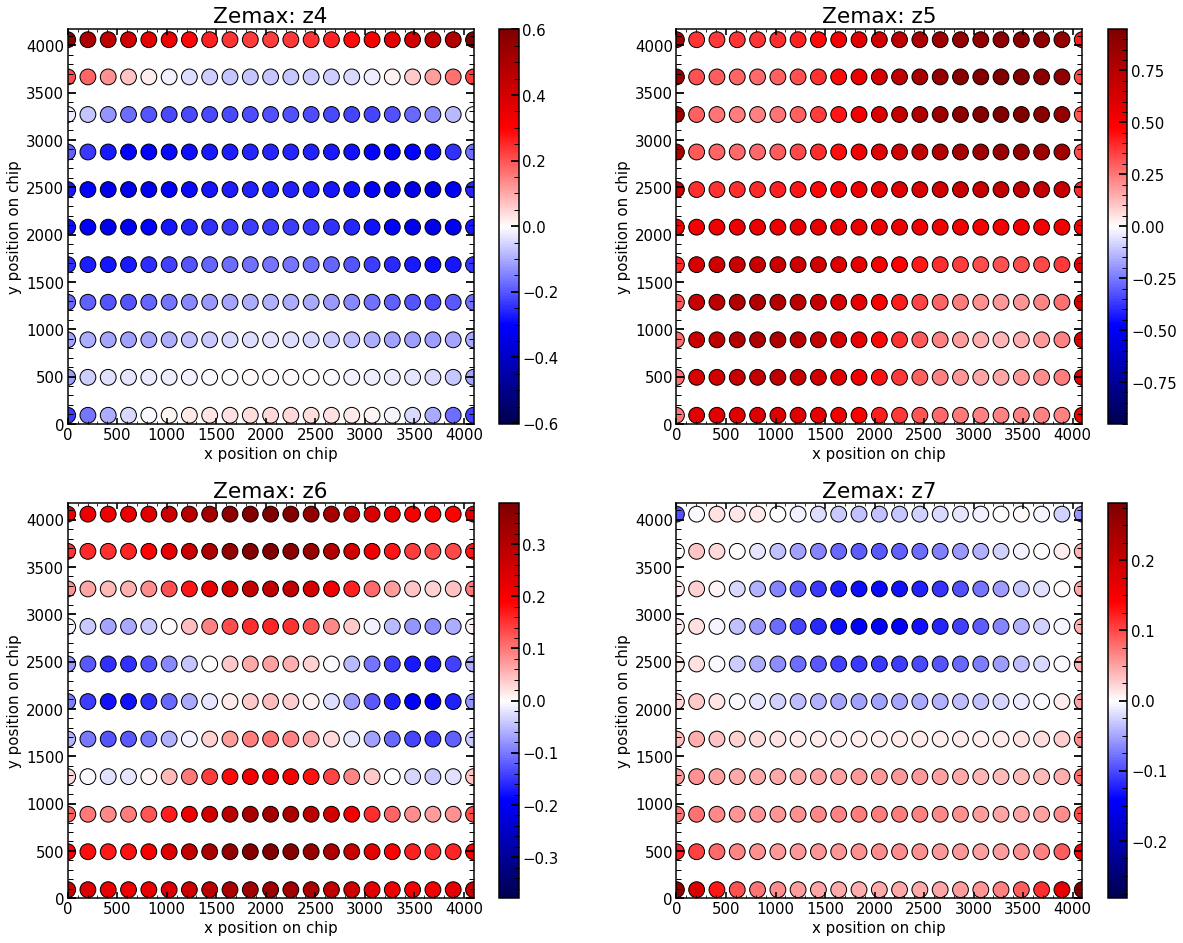

In [129]:
plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
values=np.array(wavelength_correction(single_Zernike_res_z4))
plt.scatter(x, y, s=area, c=values, cmap='seismic', alpha=1,vmin=-np.max(np.abs(values)), vmax=np.max(np.abs(values)),edgecolor='black')
#plt.scatter(x_rotated, y_rotated, s=area, c=values, cmap='seismic', alpha=1,vmin=-np.max(np.abs(values)), vmax=np.max(np.abs(values)),edgecolor='black')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('Zemax: z'+str(4))
plt.colorbar()

plt.subplot(2,2,2)
values=np.array(wavelength_correction(single_Zernike_res_z5))
plt.scatter(x, y, s=area, c=values, cmap='seismic', alpha=1,vmin=-np.max(np.abs(values)), vmax=np.max(np.abs(values)),edgecolor='black')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('Zemax: z'+str(5))
plt.colorbar()

plt.subplot(2,2,3)
values=np.array(wavelength_correction(single_Zernike_res_z6))
plt.scatter(x, y, s=area, c=values, cmap='seismic', alpha=1,vmin=-np.max(np.abs(values)), vmax=np.max(np.abs(values)),edgecolor='black')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('Zemax: z'+str(6))
plt.colorbar()

plt.subplot(2,2,4)
values=np.array(wavelength_correction(single_Zernike_res_z7))
plt.scatter(x, y, s=area, c=values, cmap='seismic', alpha=1,vmin=-np.max(np.abs(values)), vmax=np.max(np.abs(values)),edgecolor='black')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('Zemax: z'+str(7))
plt.colorbar()

## Wavefront rms 

In [108]:

date='Dec17'
obs=21400
single_number='9'
image_index=int(single_number)
eps=5
arc='HgAr'
dataset=4

if dataset==2:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Stamps_cleaned/"
if dataset==3:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Jun_25/Stamps_cleaned/"
if dataset==4:
    STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/"    

if dataset==1:
    if arc=="HgAr":
        single_number_focus=11748
    elif arc=="Ne":
        single_number_focus=11748+607    
    else:
        print("Not recognized arc-line")
        
if dataset==2:
    if arc=="HgAr":
        single_number_focus=17017+54
    elif arc=="Ne":
        single_number_focus=16292  
    elif arc=="Kr":
        single_number_focus=17364  
    else:
        print("Not recognized arc-line")
        
if dataset==3:
    if arc=="HgAr":
        single_number_focus=19238+54
    elif arc=="Ne":
        single_number_focus=19472  
    else:
        print("Not recognized arc-line")
      
if dataset==4:
    if arc=="HgAr":
        single_number_focus=21346+54
    elif arc=="Ne":
        single_number_focus=21550 +54 
    elif arc=="Kr":
        single_number_focus=21754  +54 
    else:
        print("Not recognized arc-line")    
    
if dataset==1:
    if arc=='HgAr':
        obs_possibilites=np.array([11796,11790,11784,11778,11772,11766,11760,11754,11748,11748,11694,11700,11706,11712,11718,11724,11730,11736])
    elif arc=='Ne':
        obs_possibilites=np.array([12403,12397,12391,12385,12379,12373,12367,12361,12355,12355,12349,12343,12337,12331,12325,12319,12313,12307])
        
if dataset==2:
    if arc=='HgAr':
        obs_possibilites=np.array([17023,17023+6,17023+12,17023+18,17023+24,17023+30,17023+36,17023+42,17023+48,17023+48,\
                                   17023+54,17023+60,17023+66,17023+72,17023+78,17023+84,17023+90,17023+96,17023+48])
    if arc=='Ne':
        # different sequence than for HgAr
        obs_possibilites=np.array([16238+6,16238+12,16238+18,16238+24,16238+30,16238+36,16238+42,16238+48,16238+54,16238+54,\
                                   16238+60,16238+66,16238+72,16238+78,16238+84,16238+90,16238+96,16238+102,16238+54])
    if arc=='Kr':
         obs_possibilites=np.array([17310+6,17310+12,17310+18,17310+24,17310+30,17310+36,17310+42,17310+48,17310+54,17310+54,\
                                    17310+60,17310+66,17310+72,17310+78,17310+84,17310+90,17310+96,17310+102,17310+54])

if dataset==3:    
    if arc=='HgAr':
        obs_possibilites=np.array([19238,19238+6,19238+12,19238+18,19238+24,19238+30,19238+36,19238+42,19238+48,19238+48,\
                                   19238+54,19238+60,19238+66,19238+72,19238+78,19238+84,19238+90,19238+96,19238+48])
    elif arc=='Ne':
    # different sequence than for HgAr
        obs_possibilites=np.array([19472+6,19472+12,19472+18,19472+24,19472+30,19472+36,19472+42,19472+48,19472+54,19472+54,\
                                   19472+60,19472+66,19472+72,19472+78,19472+84,19472+90,19472+96,19472+102,19472+54]) 
  
if dataset==4:
    if arc=='HgAr':
        obs_possibilites=np.array([21346+6,21346+12,21346+18,21346+24,21346+30,21346+36,21346+42,21346+48,21346+54,21346+54,\
                                   21346+60,21346+66,21346+72,21346+78,21346+84,21346+90,21346+96,21346+102,21346+48])
    if arc=='Ne':
        obs_possibilites=np.array([21550+6,21550+12,21550+18,21550+24,21550+30,21550+36,21550+42,21550+48,21550+54,21550+54,\
                                   21550+60,21550+66,21550+72,21550+78,21550+84,21550+90,21550+96,21550+102,21550+54])
    if arc=='Kr':
         obs_possibilites=np.array([21754+6,21754+12,21754+18,21754+24,21754+30,21754+36,21754+42,21754+48,21754+54,21754+54,\
                                    21754+60,21754+66,21754+72,21754+78,21754+84,21754+90,21754+96,21754+102,21754+54])
        
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]
print(labelInput)
if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if dataset==1:
    if arc=="HgAr":
        finalArc=finalHgAr_Feb2019
    elif arc=="Ne":
        finalArc=finalNe_Feb2019    
    else:
        print("Not recognized arc-line")  
        
if dataset==2:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==3:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    else:
        print("Not recognized arc-line")   
        
if dataset==4:   
    if arc=="HgAr":
        finalArc=finalHgAr_May2019
    elif arc=="Ne":
        finalArc=finalNe_May2019    
    elif arc=="Kr":
        finalArc=finalKr_May2019    
    else:
        print("Not recognized arc-line")           
        
finalArc.loc[int(single_number)]

0d


fiber                           2
xc                             66
yc                           3395
wavelength               912.5693
close                           1
lamp                         HgAr
xc_effective                   66
old_index_approx                9
superold_index_approx        20.0
Name: 9, dtype: object

In [55]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_May2019.pkl', 'rb') as f:
    finalNe_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_May2019.pkl', 'rb') as f:
    finalHgAr_May2019=pickle.load(f)  
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_May2019.pkl', 'rb') as f:
    finalKr_May2019=pickle.load(f)  
    
finalKr=finalKr_May2019
finalHgAr=finalHgAr_May2019
finalNe=finalNe_May2019

In [50]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_HgAr_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_HgAr_from_Dec17=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_Ne_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_Ne_from_Dec17=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec17_Focus/' + 'results_of_fit_many_direct_Kr_from_Dec17.pkl', 'rb') as f:
    results_of_fit_many_direct_Kr_from_Dec17=pickle.load(f)

In [51]:
results_of_fit_many_direct_HgAr_from_Dec17.index.values

array([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  27,  30,  33,
        35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,  63,
        66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,  95,
        97,  99, 102, 105, 107, 109, 111, 114, 117, 119])

In [52]:

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]list_of_wf_grid=[]

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]
list_of_wf_grid_HgAr_0=[]
list_of_wf_grid_HgAr_0_and_focus_0=[]


arc='HgAr'
obs=21346+54
for single_number in tqdm(results_of_fit_many_direct_HgAr_from_Dec17.index.values):
    minchain=results_of_fit_many_direct_HgAr_from_Dec17.loc[single_number].values[:42]

    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_HgAr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
 
    list_of_wf_grid_HgAr.append(wf_grid)

    # eliminating values for 
    minchain_0=np.copy(minchain)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0.append(wf_grid)
    
    # also eliminating defocus value z4-z22
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0_and_focus_0.append(wf_grid)

for single_number in tqdm(results_of_fit_many_direct_HgAr_from_Dec17.index.values):

SyntaxError: unexpected EOF while parsing (<ipython-input-52-828bd29c7576>, line 1)

In [53]:
results_of_fit_many_direct_HgAr_from_Dec17.index.values[0]

1

In [62]:
finalHgAr_May2019.iloc[1][['xc','yc']].values

array([69, 875], dtype=object)

In [63]:
x

array([2048, 2252, 2457, 2662, 2867, 3072, 3276, 3481, 3686, 3891, 4096,
          0, 1843, 1638, 1433, 1228, 1024,  819,  614,  409,  204, 2048,
       2252, 2457, 2662, 2867, 3072, 3276, 3481, 3686, 3891, 4096,    0,
       1843, 1638, 1433, 1228, 1024,  819,  614,  409,  204, 2048, 2252,
       2457, 2662, 2867, 3072, 3276, 3481, 3686, 3891, 4096,    0, 1843,
       1638, 1433, 1228, 1024,  819,  614,  409,  204, 2048, 2252, 2457,
       2662, 2867, 3072, 3276, 3481, 3686, 3891, 4096,    0, 1843, 1638,
       1433, 1228, 1024,  819,  614,  409,  204, 2048, 2252, 2457, 2662,
       2867, 3072, 3276, 3481, 3686, 3891, 4096,    0, 1843, 1638, 1433,
       1228, 1024,  819,  614,  409,  204, 2048, 2252, 2457, 2662, 2867,
       3072, 3276, 3481, 3686, 3891, 4096,    0, 1843, 1638, 1433, 1228,
       1024,  819,  614,  409,  204, 2048, 2252, 2457, 2662, 2867, 3072,
       3276, 3481, 3686, 3891, 4096,    0, 1843, 1638, 1433, 1228, 1024,
        819,  614,  409,  204, 2048, 2252, 2457, 26

In [81]:
Zernike_single_Zemax=[]

x_position=finalHgAr_May2019.iloc[1]['xc']
y_position=finalHgAr_May2019.iloc[1]['yc']

for i in [single_Zernike_res_z4,single_Zernike_res_z5,single_Zernike_res_z6,single_Zernike_res_z7,single_Zernike_res_z8,single_Zernike_res_z9,single_Zernike_res_z10,single_Zernike_res_z11,\
         single_Zernike_res_z12,single_Zernike_res_z13,single_Zernike_res_z14,single_Zernike_res_z15,single_Zernike_res_z16,single_Zernike_res_z17,single_Zernike_res_z18,\
          single_Zernike_res_z19,single_Zernike_res_z20,single_Zernike_res_z21,single_Zernike_res_z22]:
    Zernike_single_Zemax.append(scipy.interpolate.SmoothBivariateSpline(x,y,np.array(wavelength_correction(i)))(x_position,y_position)[0][0])

In [78]:
Zernike_single_Zemax=np.array(Zernike_single_Zemax)
Zernike_single_Zemax

array([-0.13130879,  0.41509238,  0.06414604,  0.09224901,  0.00734821,
       -0.02016886, -0.18513287,  0.00836944,  0.07772098,  0.00251068,
        0.00815661, -0.00210975, -0.02197216,  0.01339144,  0.02028477,
       -0.01421675,  0.00502621,  0.00068521,  0.        ])

In [82]:
Zernike_single_Zemax

[-0.14602488392780674,
 0.4367871379456539,
 0.017716711943527967,
 0.07024328743528228,
 0.002818315263000529,
 0.0028573215785303537,
 -0.1979207777717424,
 0.046591059332904056,
 0.09235481091245364,
 -0.003357068875549644,
 0.0037939599347870537,
 -0.0014782759452029825,
 -0.022155794142603737,
 0.011115767149797347,
 0.02028271258920176,
 -0.013361185371552346,
 0.004843292905449146,
 4.143065086596038e-05,
 0.0]

In [94]:
minchain=results_of_fit_many_direct_HgAr_from_Dec17.loc[1].values[:42]
minchain_Zemax=np.copy(minchain)

minchain_Zemax[0:19]=Zernike_single_Zemax
minchain_Zemax

array([   -0.14602488,     0.43678714,     0.01771671,     0.07024329,
           0.00281832,     0.00285732,    -0.19792078,     0.04659106,
           0.09235481,    -0.00335707,     0.00379396,    -0.00147828,
          -0.02215579,     0.01111577,     0.02028271,    -0.01336119,
           0.00484329,     0.00004143,     0.        ,     0.68633122,
           0.09974333,    -0.1900477 ,    -0.04529421,     0.05214261,
           0.05087747,     0.00004148,     0.00004146,     0.9749291 ,
           0.94835567,     0.03885964,    -0.05278661,     0.92055316,
           0.05681748,     0.62724215,     1.00053215,     0.61525985,
       44687.82746289,     1.92366563,     0.00074594,     0.35      ,
           1.78193719,     0.99946374])

In [109]:
list_of_wf_grid=[]

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]
list_of_wf_grid_HgAr_0=[]
list_of_wf_grid_HgAr_0_and_focus_0=[]


arc='HgAr'
obs=21346+54
for single_number in tqdm(results_of_fit_many_direct_HgAr_from_Dec17.index.values):
    minchain=results_of_fit_many_direct_HgAr_from_Dec17.loc[single_number].values[:42]
   
    Zernike_single_Zemax=[]
    x_position=finalHgAr_May2019.iloc[single_number]['xc']
    y_position=finalHgAr_May2019.iloc[single_number]['yc']

    for i in [single_Zernike_res_z4,single_Zernike_res_z5,single_Zernike_res_z6,single_Zernike_res_z7,single_Zernike_res_z8,single_Zernike_res_z9,single_Zernike_res_z10,single_Zernike_res_z11,\
             single_Zernike_res_z12,single_Zernike_res_z13,single_Zernike_res_z14,single_Zernike_res_z15,single_Zernike_res_z16,single_Zernike_res_z17,single_Zernike_res_z18,\
              single_Zernike_res_z19,single_Zernike_res_z20,single_Zernike_res_z21,single_Zernike_res_z22]:
        Zernike_single_Zemax.append(scipy.interpolate.SmoothBivariateSpline(x,y,np.array(wavelength_correction(i)))(x_position,y_position)[0][0])    
    
    minchain_Zemax=np.copy(minchain)
    minchain_Zemax[0:19]=Zernike_single_Zemax
    
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain_Zemax)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_HgAr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
 
    list_of_wf_grid_HgAr.append(wf_grid)

    # eliminating values for 
    minchain_0=np.copy(minchain_Zemax)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0.append(wf_grid)
    
    # also eliminating defocus value z4-z22
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0_and_focus_0.append(wf_grid)
    
    
    
wavefront_values_Ne=[]
list_of_wf_grid_Ne=[]
list_of_wf_grid_Ne_0=[]
list_of_wf_grid_Ne_0_and_focus_0=[]
arc='Ne'
obs=21550 +54
for single_number in tqdm(results_of_fit_many_direct_Ne_from_Dec17.index.values):
    minchain=results_of_fit_many_direct_Ne_from_Dec17.loc[single_number].values[:42]

    Zernike_single_Zemax=[]
    x_position=finalNe_May2019.iloc[single_number]['xc']
    y_position=finalNe_May2019.iloc[single_number]['yc']

    for i in [single_Zernike_res_z4,single_Zernike_res_z5,single_Zernike_res_z6,single_Zernike_res_z7,single_Zernike_res_z8,single_Zernike_res_z9,single_Zernike_res_z10,single_Zernike_res_z11,\
             single_Zernike_res_z12,single_Zernike_res_z13,single_Zernike_res_z14,single_Zernike_res_z15,single_Zernike_res_z16,single_Zernike_res_z17,single_Zernike_res_z18,\
              single_Zernike_res_z19,single_Zernike_res_z20,single_Zernike_res_z21,single_Zernike_res_z22]:
        Zernike_single_Zemax.append(scipy.interpolate.SmoothBivariateSpline(x,y,np.array(wavelength_correction(i)))(x_position,y_position)[0][0])    

    minchain_Zemax=np.copy(minchain)
    minchain_Zemax[0:19]=Zernike_single_Zemax
    
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)    

    model(minchain_Zemax)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_Ne.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    list_of_wf_grid_Ne.append(wf_grid)
    
    minchain_0=np.copy(minchain_Zemax)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Ne_0.append(wf_grid)
        
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Ne_0_and_focus_0.append(wf_grid)
    
 
wavefront_values_Kr=[]
list_of_wf_grid_Kr=[]
list_of_wf_grid_Kr_0=[]
list_of_wf_grid_Kr_0_and_focus_0=[]
arc='Kr'
obs=21754+54 
for single_number in tqdm(results_of_fit_many_direct_Kr_from_Dec17.index.values):
    minchain=results_of_fit_many_direct_Kr_from_Dec17.loc[single_number].values[:42]

    Zernike_single_Zemax=[]
    x_position=finalKr_May2019.iloc[single_number]['xc']
    y_position=finalKr_May2019.iloc[single_number]['yc']

    for i in [single_Zernike_res_z4,single_Zernike_res_z5,single_Zernike_res_z6,single_Zernike_res_z7,single_Zernike_res_z8,single_Zernike_res_z9,single_Zernike_res_z10,single_Zernike_res_z11,\
             single_Zernike_res_z12,single_Zernike_res_z13,single_Zernike_res_z14,single_Zernike_res_z15,single_Zernike_res_z16,single_Zernike_res_z17,single_Zernike_res_z18,\
              single_Zernike_res_z19,single_Zernike_res_z20,single_Zernike_res_z21,single_Zernike_res_z22]:
        Zernike_single_Zemax.append(scipy.interpolate.SmoothBivariateSpline(x,y,np.array(wavelength_correction(i)))(x_position,y_position)[0][0])    

    minchain_Zemax=np.copy(minchain)
    minchain_Zemax[0:19]=Zernike_single_Zemax
    
    
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    mask_image =np.load(STAMPS_FOLDER+'mask'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')


    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22,verbosity=0)   

    model(minchain_Zemax)

    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    wavefront_values_Kr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    list_of_wf_grid_Kr.append(wf_grid)

    minchain_0=np.copy(minchain_Zemax)
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Kr_0.append(wf_grid)
    
    minchain_0_and_focus_0=np.copy(minchain_0)
    minchain_0_and_focus_0[0]=0
    minchain_0_and_focus_0[7]=0
    minchain_0_and_focus_0[18]=0
    model(minchain_0_and_focus_0)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_Kr_0_and_focus_0.append(wf_grid)
    
wavefront_values_HgAr=np.array(wavefront_values_HgAr)
wavefront_values_Ne=np.array(wavefront_values_Ne)
wavefront_values_Kr=np.array(wavefront_values_Kr)
    

100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


In [138]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec17'
descriptions=results_of_fit_many_direct_HgAr_from_Dec17.columns


# take values for HgAr
x_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_from_Dec17.index.astype(int).ravel()]['xc_effective'].values
y_HgAr=finalHgAr.loc[results_of_fit_many_direct_HgAr_from_Dec17.index.astype(int).ravel()]['yc'].values
values_HgAr_RMS=wavefront_values_HgAr[:,5]
values_HgAr_max_min=wavefront_values_HgAr[:,1]-wavefront_values_HgAr[:,2]
values_HgAr_mean=wavefront_values_HgAr[:,4]

# take values for Neon        
x_Ne=finalNe.loc[results_of_fit_many_direct_Ne_from_Dec17.index.astype(int).ravel()]['xc_effective'].values
y_Ne=finalNe.loc[results_of_fit_many_direct_Ne_from_Dec17.index.astype(int).ravel()]['yc'].values
values_Ne_RMS=wavefront_values_Ne[:,5]
values_Ne_max_min=wavefront_values_Ne[:,1]-wavefront_values_Ne[:,2]
values_Ne_mean=wavefront_values_Ne[:,4]

# take values for Krypton        
x_Kr=finalKr.loc[results_of_fit_many_direct_Kr_from_Dec17.index.astype(int).ravel()]['xc_effective'].values
y_Kr=finalKr.loc[results_of_fit_many_direct_Kr_from_Dec17.index.astype(int).ravel()]['yc'].values
values_Kr_RMS=wavefront_values_Kr[:,5] 
values_Kr_max_min=wavefront_values_Kr[:,1]-wavefront_values_Kr[:,2]
values_Kr_mean=wavefront_values_Kr[:,4]
#x=x_HgAr
#y=y_HgAr  
#colors=values_HgAr

# join these values
x=np.concatenate((x_HgAr,x_Ne,x_Kr))
y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
colors_RMS= np.concatenate((values_HgAr_RMS,values_Ne_RMS,values_Kr_RMS))
colors_max_min= np.concatenate((values_HgAr_max_min,values_Ne_max_min,values_Kr_max_min))
colors_mean= np.concatenate((values_HgAr_mean,values_Ne_mean,values_Kr_mean))


min_colors_RMS=np.quantile(colors_RMS,0.1)
max_colors_RMS=np.quantile(colors_RMS,0.9)
min_colors_max_min=np.quantile(colors_max_min,0.1)
max_colors_max_min=np.quantile(colors_max_min,0.9)
min_colors_mean=np.quantile(colors_mean,0.1)
max_colors_mean=np.quantile(colors_mean,0.9)

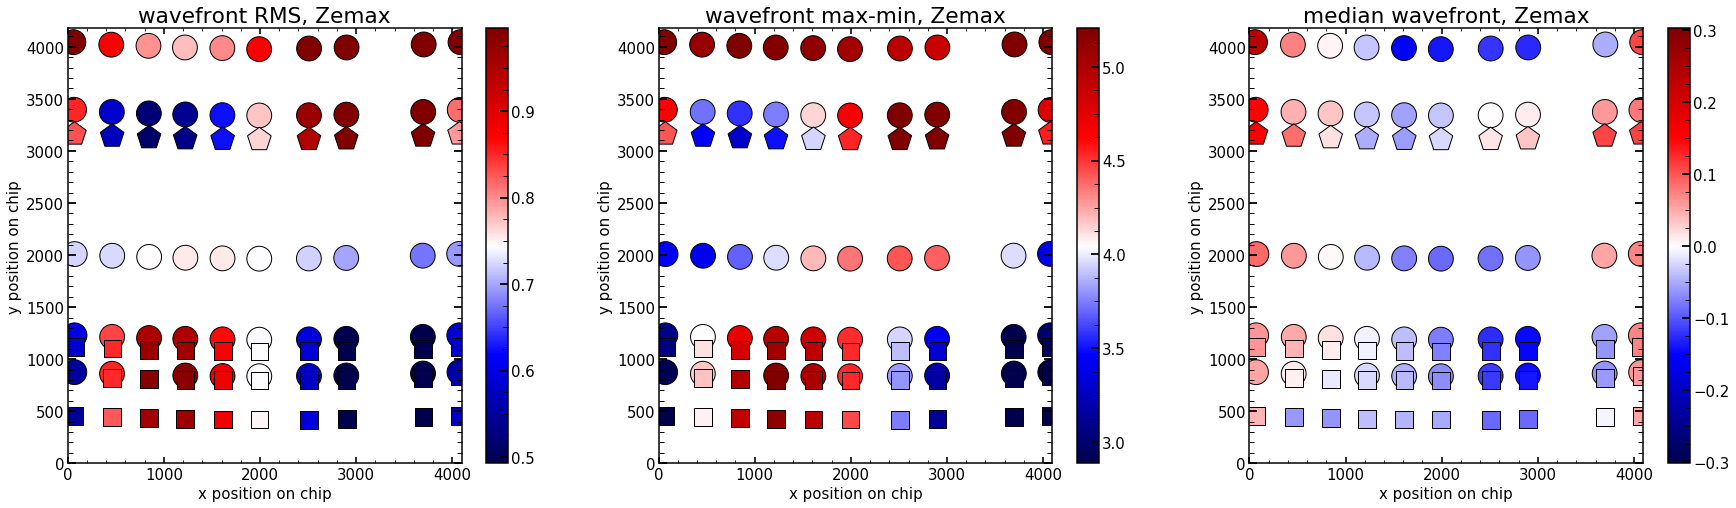

In [140]:


matplotlib.rcParams.update({'font.size': 18})


plt.figure(figsize=(30,8))

plt.subplot(131)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront RMS, Zemax')
plt.colorbar()


plt.subplot(132)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront max-min, Zemax')
plt.colorbar()

plt.subplot(133)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('median wavefront, Zemax')
plt.colorbar()

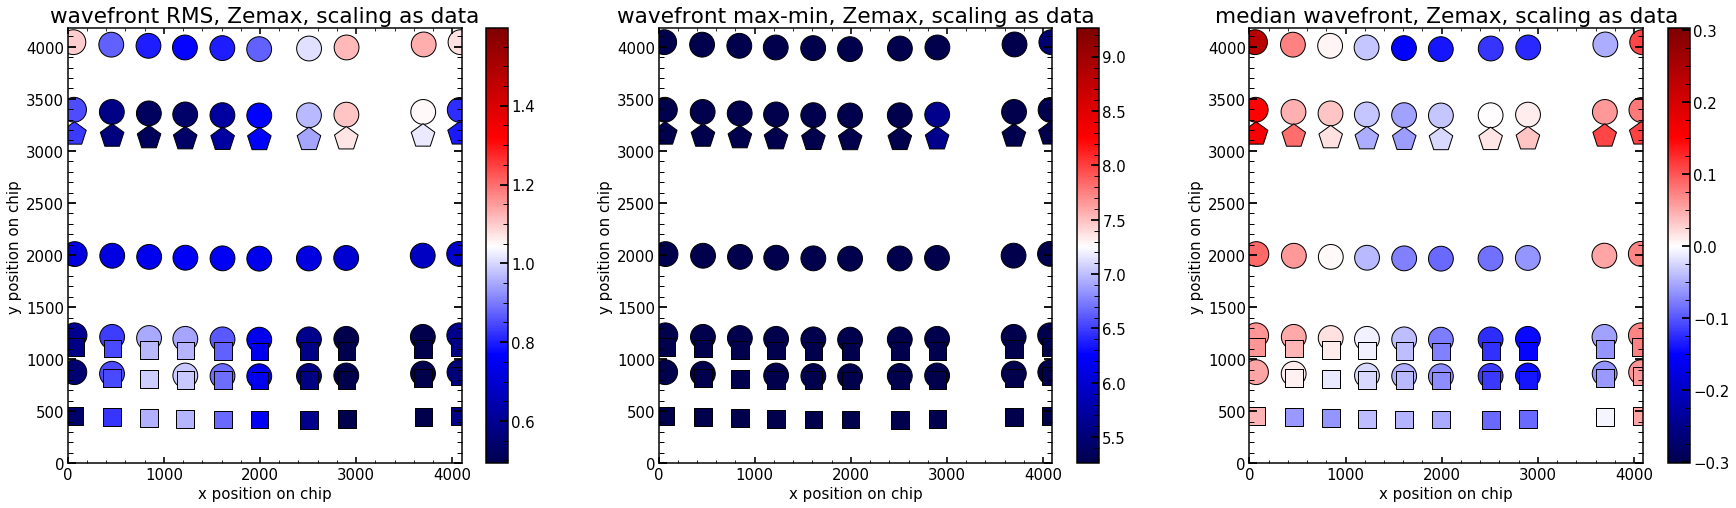

In [142]:
matplotlib.rcParams.update({'font.size': 18})

max_colors_RMS=1.596
max_colors_max_min=0.867
max_colors_max_min=9.26
min_colors_max_min=5.26
abs_colors_mean=0.302


plt.figure(figsize=(30,8))

plt.subplot(131)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront RMS, Zemax, scaling as data')
plt.colorbar()


plt.subplot(132)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront max-min, Zemax, scaling as data')
plt.colorbar()

plt.subplot(133)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=values_HgAr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('median wavefront, Zemax, scaling as data')
plt.colorbar()

## 2d

### original figure 

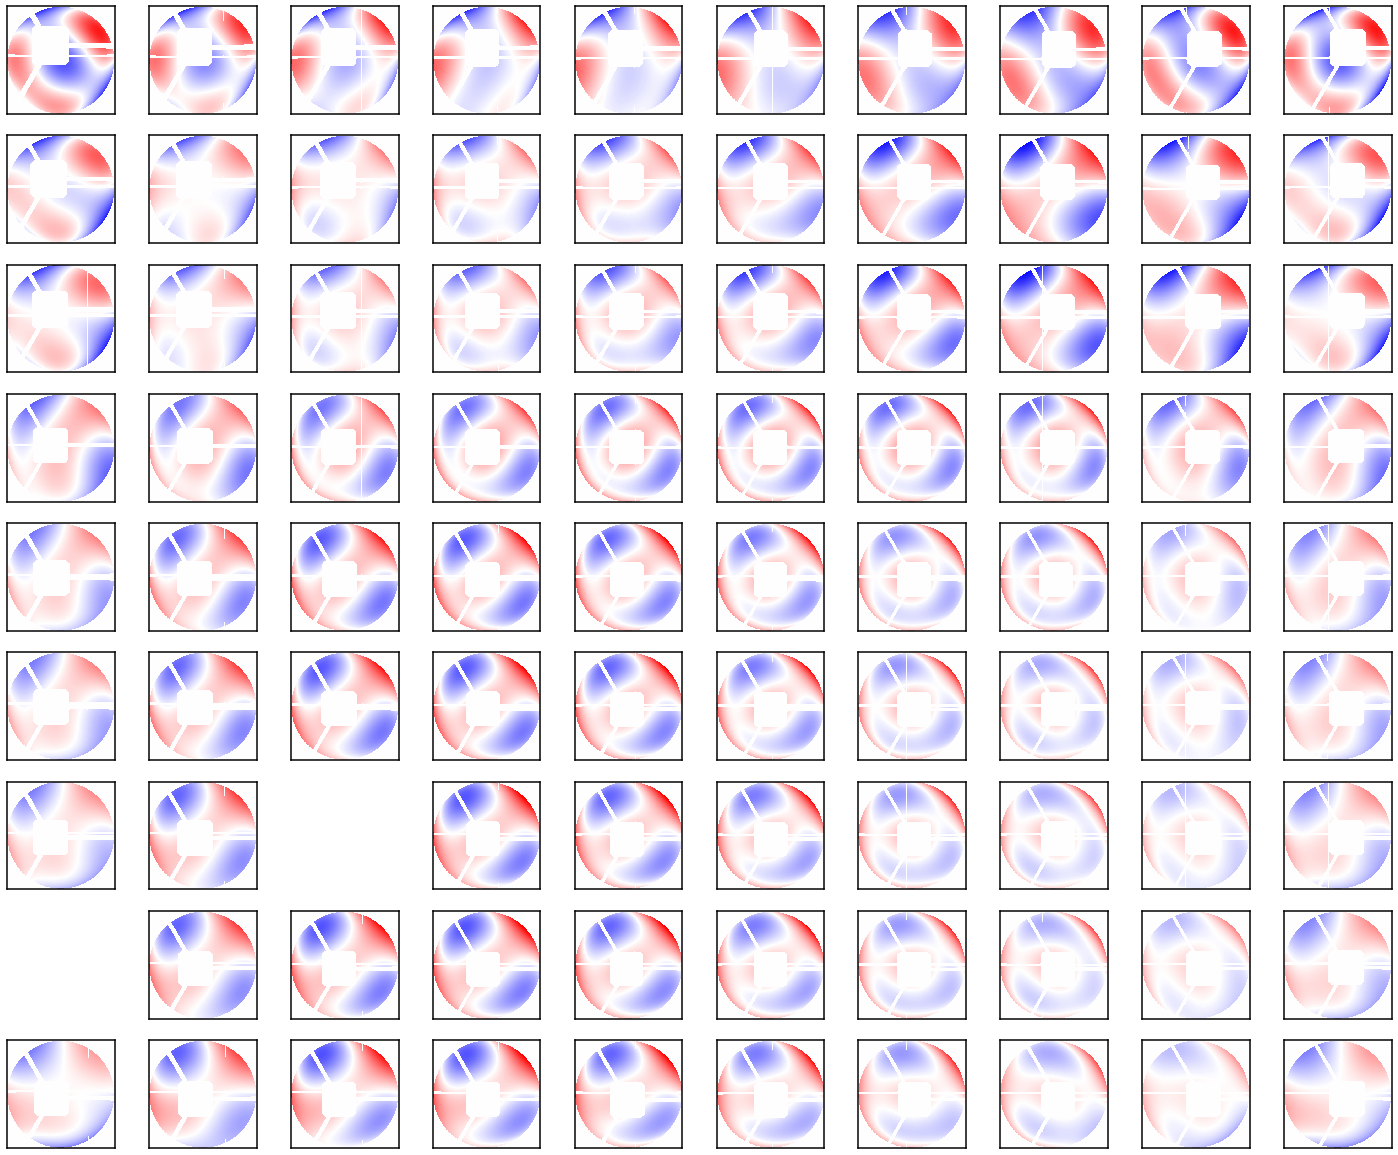

In [114]:
## matplotlib.rcParams.update({'font.size': 4})
matplotlib.rcParams.update({'axes.labelsize': 'small'})
matplotlib.rcParams.update({'xtick.labelsize': 'small'})
matplotlib.rcParams.update({'ytick.labelsize': 'small'})

y_range=9
x_range=10


plt.figure(figsize=(25,21))

# lowest Neon wavelength
# 660.0668 0,  2,  5,  8, 11, 14, 17, 20, 23, 26  
plt.subplot(y_range,x_range,81)
wavefront=list_of_wf_grid_Ne[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,82)
wavefront=list_of_wf_grid_Ne[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,83)
wavefront=list_of_wf_grid_Ne[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,84)
wavefront=list_of_wf_grid_Ne[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,85)
wavefront=list_of_wf_grid_Ne[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,86)
wavefront=list_of_wf_grid_Ne[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,87)
wavefront=list_of_wf_grid_Ne[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,88)
wavefront=list_of_wf_grid_Ne[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,89)
wavefront=list_of_wf_grid_Ne[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,90)
wavefront=list_of_wf_grid_Ne[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')
###############
# Ne 693
# 3,  6,  9, 12, 15, 18, 21, 24, 27

plt.subplot(y_range,x_range,72)
wavefront=list_of_wf_grid_Ne[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,73)
wavefront=list_of_wf_grid_Ne[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,74)
wavefront=list_of_wf_grid_Ne[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,75)
wavefront=list_of_wf_grid_Ne[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,76)
wavefront=list_of_wf_grid_Ne[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,77)
wavefront=list_of_wf_grid_Ne[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,78)
wavefront=list_of_wf_grid_Ne[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,79)
wavefront=list_of_wf_grid_Ne[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,80)
wavefront=list_of_wf_grid_Ne[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 696
#  0,  5, 14, 19, 24, 29, 34, 39, 44
plt.subplot(y_range,x_range,61)
wavefront=list_of_wf_grid_HgAr[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,62)
wavefront=list_of_wf_grid_HgAr[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,64)
wavefront=list_of_wf_grid_HgAr[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,65)
wavefront=list_of_wf_grid_HgAr[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,66)
wavefront=list_of_wf_grid_HgAr[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,67)
wavefront=list_of_wf_grid_HgAr[29][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,68)
wavefront=list_of_wf_grid_HgAr[34][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,69)
wavefront=list_of_wf_grid_HgAr[39][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,70)
wavefront=list_of_wf_grid_HgAr[44][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Ne 717
# [ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28]

plt.subplot(y_range,x_range,51)
wavefront=list_of_wf_grid_Ne[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,52)
wavefront=list_of_wf_grid_Ne[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,53)
wavefront=list_of_wf_grid_Ne[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,54)
wavefront=list_of_wf_grid_Ne[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,55)
wavefront=list_of_wf_grid_Ne[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,56)
wavefront=list_of_wf_grid_Ne[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,57)
wavefront=list_of_wf_grid_Ne[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,58)
wavefront=list_of_wf_grid_Ne[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,59)
wavefront=list_of_wf_grid_Ne[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,60)
wavefront=list_of_wf_grid_Ne[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 727
# 1,  6, 10, 15, 20, 25, 30, 35, 40, 45
plt.subplot(y_range,x_range,41)
wavefront=list_of_wf_grid_HgAr[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,42)
wavefront=list_of_wf_grid_HgAr[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,43)
wavefront=list_of_wf_grid_HgAr[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,44)
wavefront=list_of_wf_grid_HgAr[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,45)
wavefront=list_of_wf_grid_HgAr[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,46)
wavefront=list_of_wf_grid_HgAr[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,47)
wavefront=list_of_wf_grid_HgAr[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,48)
wavefront=list_of_wf_grid_HgAr[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,49)
wavefront=list_of_wf_grid_HgAr[40][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,50)
wavefront=list_of_wf_grid_HgAr[45][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 795
# [ 2,  7, 11, 16, 21, 26, 31, 36, 41, 46]

plt.subplot(y_range,x_range,31)
wavefront=list_of_wf_grid_HgAr[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,32)
wavefront=list_of_wf_grid_HgAr[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,33)
wavefront=list_of_wf_grid_HgAr[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,34)
wavefront=list_of_wf_grid_HgAr[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,35)
wavefront=list_of_wf_grid_HgAr[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,36)
wavefront=list_of_wf_grid_HgAr[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,37)
wavefront=list_of_wf_grid_HgAr[31][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,38)
wavefront=list_of_wf_grid_HgAr[36][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,39)
wavefront=list_of_wf_grid_HgAr[41][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,40)
wavefront=list_of_wf_grid_HgAr[46][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Kr 893
#0, 1, 2, 3, 4, 5, 6, 7, 8, 9
plt.subplot(y_range,x_range,21)
wavefront=list_of_wf_grid_Kr[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,22)
wavefront=list_of_wf_grid_Kr[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,23)
wavefront=list_of_wf_grid_Kr[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,24)
wavefront=list_of_wf_grid_Kr[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,25)
wavefront=list_of_wf_grid_Kr[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,26)
wavefront=list_of_wf_grid_Kr[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,27)
wavefront=list_of_wf_grid_Kr[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,28)
wavefront=list_of_wf_grid_Kr[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,29)
wavefront=list_of_wf_grid_Kr[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,30)
wavefront=list_of_wf_grid_Kr[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 912
#  3,  8, 12, 17, 22, 27, 32, 37, 42, 47
plt.subplot(y_range,x_range,11)
wavefront=list_of_wf_grid_HgAr[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,12)
wavefront=list_of_wf_grid_HgAr[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,13)
wavefront=list_of_wf_grid_HgAr[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,14)
wavefront=list_of_wf_grid_HgAr[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,15)
wavefront=list_of_wf_grid_HgAr[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,16)
wavefront=list_of_wf_grid_HgAr[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,17)
wavefront=list_of_wf_grid_HgAr[32][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,18)
wavefront=list_of_wf_grid_HgAr[37][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,19)
wavefront=list_of_wf_grid_HgAr[42][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,20)
wavefront=list_of_wf_grid_HgAr[47][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 966
#  4,  9, 13, 18, 23, 28, 33, 38, 43, 48
plt.subplot(y_range,x_range,1)
wavefront=list_of_wf_grid_HgAr[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,2)
wavefront=list_of_wf_grid_HgAr[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,3)
wavefront=list_of_wf_grid_HgAr[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,4)
wavefront=list_of_wf_grid_HgAr[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,5)
wavefront=list_of_wf_grid_HgAr[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,6)
wavefront=list_of_wf_grid_HgAr[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,7)
wavefront=list_of_wf_grid_HgAr[33][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,8)
wavefront=list_of_wf_grid_HgAr[38][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,9)
wavefront=list_of_wf_grid_HgAr[43][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,10)
wavefront=list_of_wf_grid_HgAr[48][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

### wavefront_0

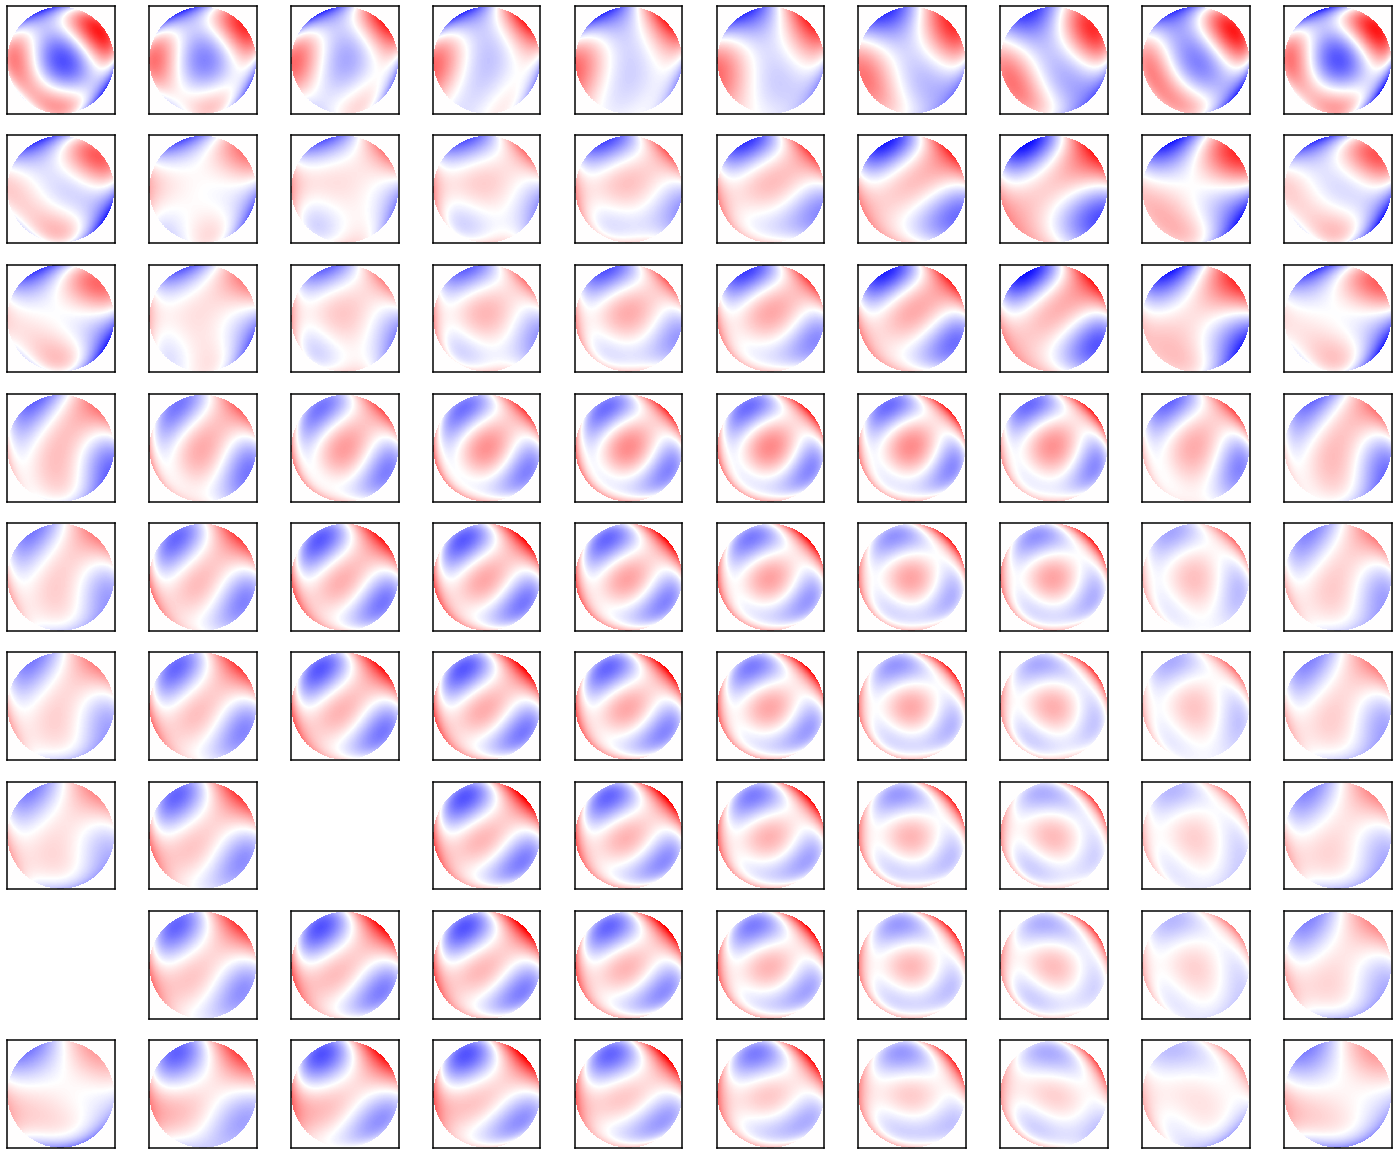

In [115]:
## matplotlib.rcParams.update({'font.size': 4})
matplotlib.rcParams.update({'axes.labelsize': 'small'})
matplotlib.rcParams.update({'xtick.labelsize': 'small'})
matplotlib.rcParams.update({'ytick.labelsize': 'small'})

y_range=9
x_range=10


plt.figure(figsize=(25,21))

# lowest Neon wavelength
# 660.0668 0,  2,  5,  8, 11, 14, 17, 20, 23, 26  
plt.subplot(y_range,x_range,81)
wavefront=list_of_wf_grid_Ne_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,82)
wavefront=list_of_wf_grid_Ne_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,83)
wavefront=list_of_wf_grid_Ne_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,84)
wavefront=list_of_wf_grid_Ne_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,85)
wavefront=list_of_wf_grid_Ne_0[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,86)
wavefront=list_of_wf_grid_Ne_0[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,87)
wavefront=list_of_wf_grid_Ne_0[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,88)
wavefront=list_of_wf_grid_Ne_0[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,89)
wavefront=list_of_wf_grid_Ne_0[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,90)
wavefront=list_of_wf_grid_Ne_0[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')
###############
# Ne 693
# 3,  6,  9, 12, 15, 18, 21, 24, 27

plt.subplot(y_range,x_range,72)
wavefront=list_of_wf_grid_Ne_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,73)
wavefront=list_of_wf_grid_Ne_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,74)
wavefront=list_of_wf_grid_Ne_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,75)
wavefront=list_of_wf_grid_Ne_0[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,76)
wavefront=list_of_wf_grid_Ne_0[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,77)
wavefront=list_of_wf_grid_Ne_0[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,78)
wavefront=list_of_wf_grid_Ne_0[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,79)
wavefront=list_of_wf_grid_Ne_0[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,80)
wavefront=list_of_wf_grid_Ne_0[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 696
#  0,  5, 14, 19, 24, 29, 34, 39, 44
plt.subplot(y_range,x_range,61)
wavefront=list_of_wf_grid_HgAr_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,62)
wavefront=list_of_wf_grid_HgAr_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,64)
wavefront=list_of_wf_grid_HgAr_0[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,65)
wavefront=list_of_wf_grid_HgAr_0[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,66)
wavefront=list_of_wf_grid_HgAr_0[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,67)
wavefront=list_of_wf_grid_HgAr_0[29][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,68)
wavefront=list_of_wf_grid_HgAr_0[34][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,69)
wavefront=list_of_wf_grid_HgAr_0[39][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,70)
wavefront=list_of_wf_grid_HgAr_0[44][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Ne 717
# [ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28]

plt.subplot(y_range,x_range,51)
wavefront=list_of_wf_grid_Ne_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,52)
wavefront=list_of_wf_grid_Ne_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,53)
wavefront=list_of_wf_grid_Ne_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,54)
wavefront=list_of_wf_grid_Ne_0[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,55)
wavefront=list_of_wf_grid_Ne_0[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,56)
wavefront=list_of_wf_grid_Ne_0[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,57)
wavefront=list_of_wf_grid_Ne_0[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,58)
wavefront=list_of_wf_grid_Ne_0[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,59)
wavefront=list_of_wf_grid_Ne_0[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,60)
wavefront=list_of_wf_grid_Ne_0[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 727
# 1,  6, 10, 15, 20, 25, 30, 35, 40, 45
plt.subplot(y_range,x_range,41)
wavefront=list_of_wf_grid_HgAr_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,42)
wavefront=list_of_wf_grid_HgAr_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,43)
wavefront=list_of_wf_grid_HgAr_0[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,44)
wavefront=list_of_wf_grid_HgAr_0[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,45)
wavefront=list_of_wf_grid_HgAr_0[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,46)
wavefront=list_of_wf_grid_HgAr_0[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,47)
wavefront=list_of_wf_grid_HgAr_0[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,48)
wavefront=list_of_wf_grid_HgAr_0[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,49)
wavefront=list_of_wf_grid_HgAr_0[40][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,50)
wavefront=list_of_wf_grid_HgAr_0[45][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 795
# [ 2,  7, 11, 16, 21, 26, 31, 36, 41, 46]

plt.subplot(y_range,x_range,31)
wavefront=list_of_wf_grid_HgAr_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,32)
wavefront=list_of_wf_grid_HgAr_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,33)
wavefront=list_of_wf_grid_HgAr_0[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,34)
wavefront=list_of_wf_grid_HgAr_0[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,35)
wavefront=list_of_wf_grid_HgAr_0[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,36)
wavefront=list_of_wf_grid_HgAr_0[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,37)
wavefront=list_of_wf_grid_HgAr_0[31][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,38)
wavefront=list_of_wf_grid_HgAr_0[36][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,39)
wavefront=list_of_wf_grid_HgAr_0[41][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,40)
wavefront=list_of_wf_grid_HgAr_0[46][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Kr 893
#0, 1, 2, 3, 4, 5, 6, 7, 8, 9
plt.subplot(y_range,x_range,21)
wavefront=list_of_wf_grid_Kr_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,22)
wavefront=list_of_wf_grid_Kr_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,23)
wavefront=list_of_wf_grid_Kr_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,24)
wavefront=list_of_wf_grid_Kr_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,25)
wavefront=list_of_wf_grid_Kr_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,26)
wavefront=list_of_wf_grid_Kr_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,27)
wavefront=list_of_wf_grid_Kr_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,28)
wavefront=list_of_wf_grid_Kr_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,29)
wavefront=list_of_wf_grid_Kr_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,30)
wavefront=list_of_wf_grid_Kr_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 912
#  3,  8, 12, 17, 22, 27, 32, 37, 42, 47
plt.subplot(y_range,x_range,11)
wavefront=list_of_wf_grid_HgAr_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,12)
wavefront=list_of_wf_grid_HgAr_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,13)
wavefront=list_of_wf_grid_HgAr_0[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,14)
wavefront=list_of_wf_grid_HgAr_0[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,15)
wavefront=list_of_wf_grid_HgAr_0[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,16)
wavefront=list_of_wf_grid_HgAr_0[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,17)
wavefront=list_of_wf_grid_HgAr_0[32][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,18)
wavefront=list_of_wf_grid_HgAr_0[37][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,19)
wavefront=list_of_wf_grid_HgAr_0[42][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,20)
wavefront=list_of_wf_grid_HgAr_0[47][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 966
#  4,  9, 13, 18, 23, 28, 33, 38, 43, 48
plt.subplot(y_range,x_range,1)
wavefront=list_of_wf_grid_HgAr_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,2)
wavefront=list_of_wf_grid_HgAr_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,3)
wavefront=list_of_wf_grid_HgAr_0[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,4)
wavefront=list_of_wf_grid_HgAr_0[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,5)
wavefront=list_of_wf_grid_HgAr_0[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,6)
wavefront=list_of_wf_grid_HgAr_0[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,7)
wavefront=list_of_wf_grid_HgAr_0[33][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,8)
wavefront=list_of_wf_grid_HgAr_0[38][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,9)
wavefront=list_of_wf_grid_HgAr_0[43][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,10)
wavefront=list_of_wf_grid_HgAr_0[48][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

### wavefront_0_focus_0

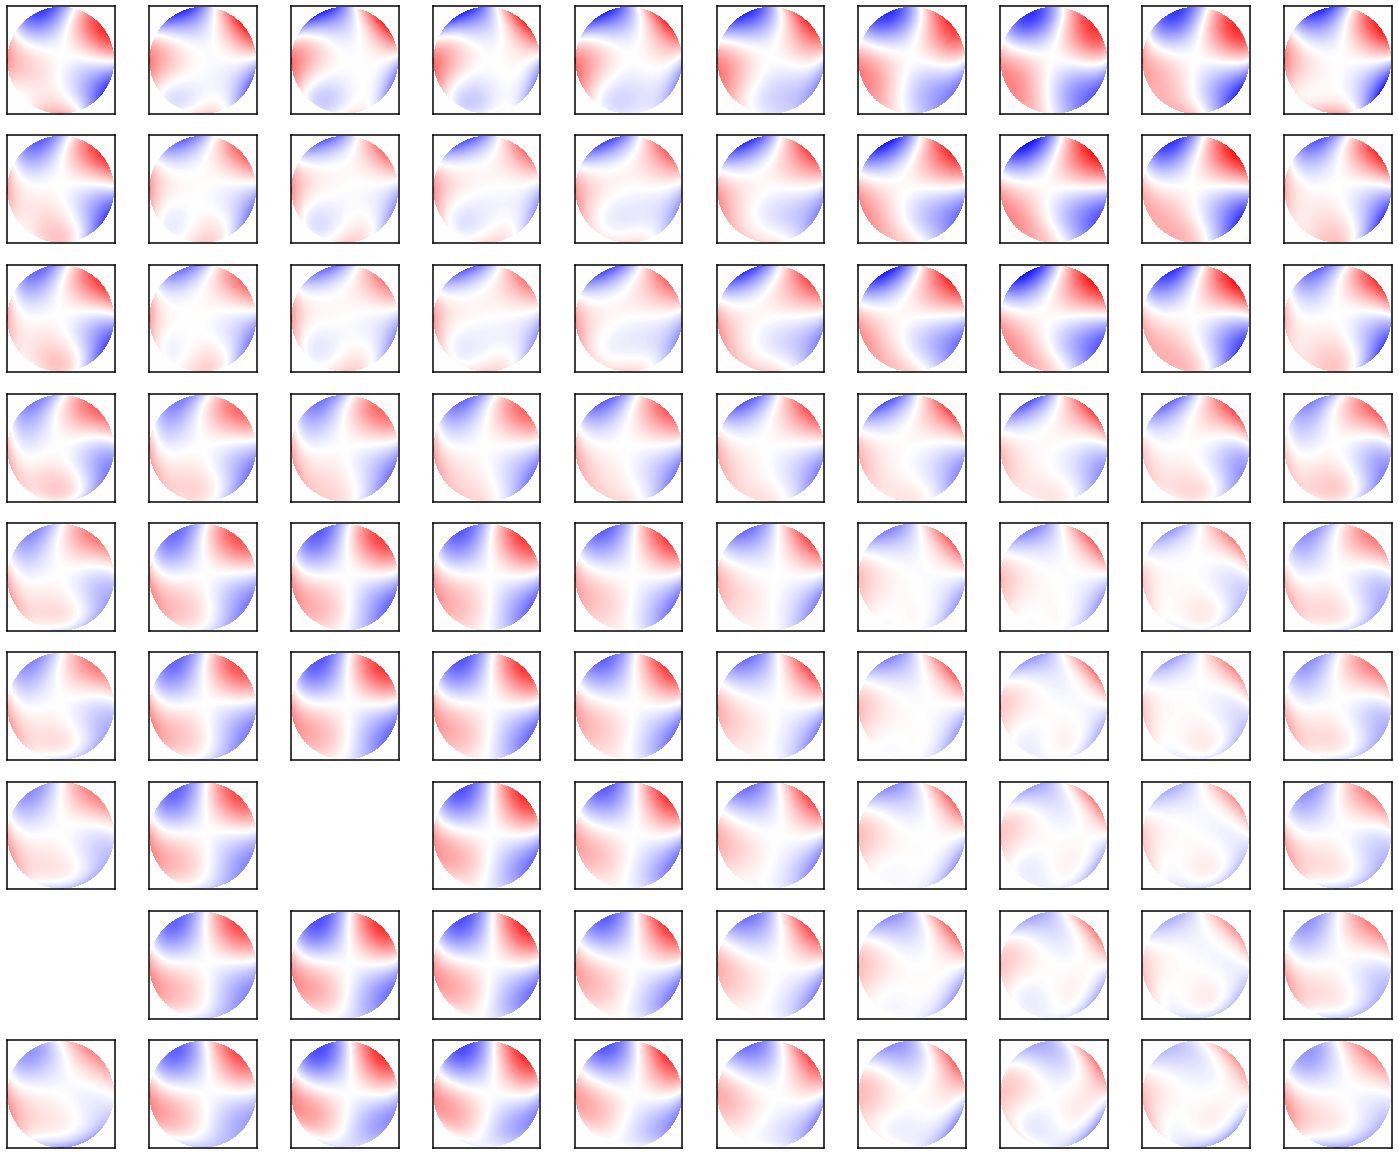

In [116]:
## matplotlib.rcParams.update({'font.size': 4})
matplotlib.rcParams.update({'axes.labelsize': 'small'})
matplotlib.rcParams.update({'xtick.labelsize': 'small'})
matplotlib.rcParams.update({'ytick.labelsize': 'small'})

y_range=9
x_range=10


plt.figure(figsize=(25,21))

# lowest Neon wavelength
# 660.0668 0,  2,  5,  8, 11, 14, 17, 20, 23, 26  
plt.subplot(y_range,x_range,81)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,82)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,83)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,84)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,85)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,86)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,87)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,88)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,89)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,90)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')
###############
# Ne 693
# 3,  6,  9, 12, 15, 18, 21, 24, 27

plt.subplot(y_range,x_range,72)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,73)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,74)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,75)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,76)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,77)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,78)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,79)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,80)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 696
#  0,  5, 14, 19, 24, 29, 34, 39, 44
plt.subplot(y_range,x_range,61)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,62)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,64)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[14][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,65)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,66)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[24][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,67)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[29][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,68)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[34][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,69)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[39][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,70)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[44][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Ne 717
# [ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28]

plt.subplot(y_range,x_range,51)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,52)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,53)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,54)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,55)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,56)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,57)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[19][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,58)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,59)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,60)
wavefront=list_of_wf_grid_Ne_0_and_focus_0[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 727
# 1,  6, 10, 15, 20, 25, 30, 35, 40, 45
plt.subplot(y_range,x_range,41)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,42)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,43)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[10][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,44)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[15][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,45)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[20][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,46)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[25][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,47)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,48)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[30][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,49)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[40][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,50)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[45][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 795
# [ 2,  7, 11, 16, 21, 26, 31, 36, 41, 46]

plt.subplot(y_range,x_range,31)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,32)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,33)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[11][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,34)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[16][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,35)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[21][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,36)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[26][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,37)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[31][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,38)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[36][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,39)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[41][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,40)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[46][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# Kr 893
#0, 1, 2, 3, 4, 5, 6, 7, 8, 9
plt.subplot(y_range,x_range,21)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[0][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,22)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[1][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,23)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[2][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,24)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,25)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,26)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[5][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,27)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[6][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,28)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[7][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,29)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,30)
wavefront=list_of_wf_grid_Kr_0_and_focus_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 912
#  3,  8, 12, 17, 22, 27, 32, 37, 42, 47
plt.subplot(y_range,x_range,11)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[3][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,12)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[8][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,13)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[12][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,14)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[17][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,15)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[22][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,16)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[27][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,17)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[32][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,18)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[37][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,19)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[42][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,20)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[47][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

###############
# HgAr 966
#  4,  9, 13, 18, 23, 28, 33, 38, 43, 48
plt.subplot(y_range,x_range,1)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[4][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,2)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[9][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,3)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[13][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,4)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[18][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,5)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[23][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,6)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[28][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,7)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[33][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,8)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[38][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,9)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[43][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')

plt.subplot(y_range,x_range,10)
wavefront=list_of_wf_grid_HgAr_0_and_focus_0[48][320:840,320:840]
plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')